In [1]:
import itertools
from copy import copy
from dataclasses import dataclass, field
from typing import Dict, List, Set, Tuple

import fiona
import geopandas as gp
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
import seaborn as sns
import tqdm
from amplpy import AMPL, add_to_path
from matplotlib import colormaps, colors
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from shapely import intersection, unary_union
from shapely.geometry import Point, Polygon

## Import Data

In [2]:
denver_gdf = ox.geocode_to_gdf("Denver, CO")
central_denver_gdf = gp.GeoDataFrame(
    geometry=gp.GeoSeries(
        intersection(
            denver_gdf.geometry.iloc[0],
            Polygon([(-105.2, 39.6), (-105.2, 39.8), (-104.85, 39.8), (-104.85, 39.6)]),
        ),
        crs=denver_gdf.crs,
    ),
    crs=denver_gdf.crs,
)
denver_hull = (
    denver_gdf.to_crs("ESRI:103245").buffer(5_000).to_crs("EPSG:4326").convex_hull[0]
)

<AxesSubplot:>

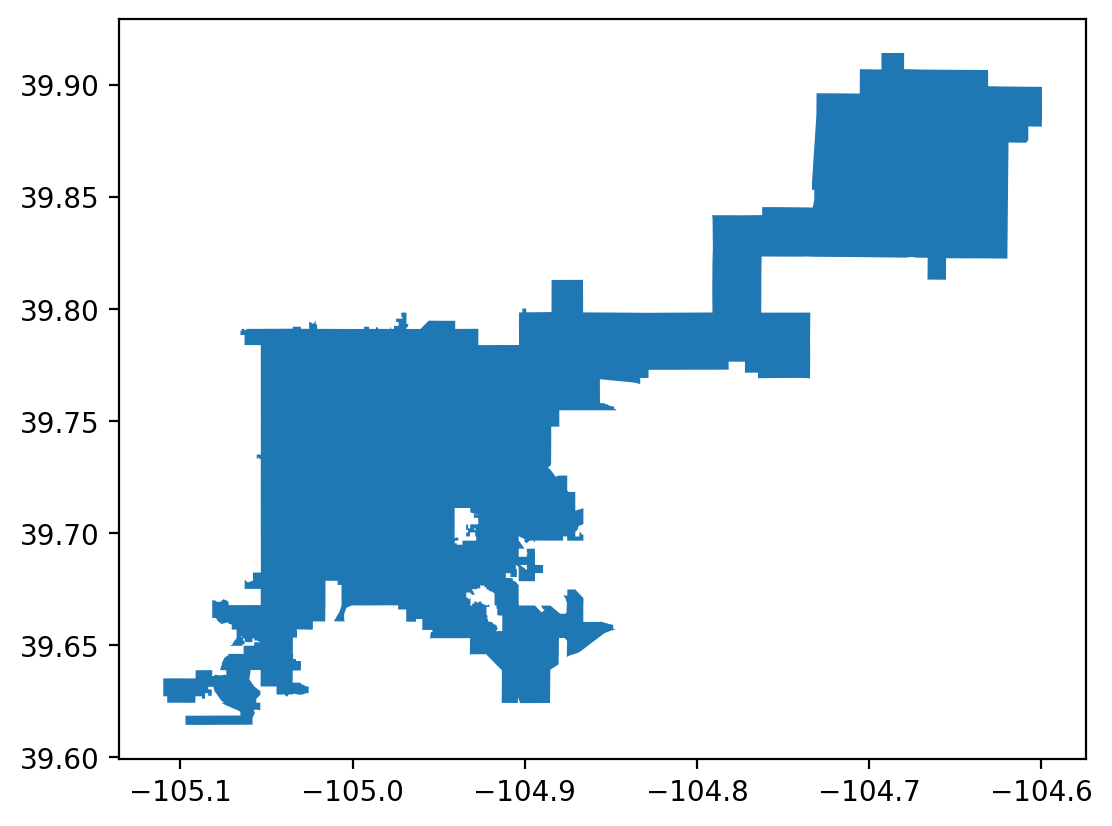

In [3]:
denver_gdf.plot()

### Load Smart Locations DB for Employment Numbers

In [4]:
smart_locations_db = gp.read_file(
    "data/SMARTLOCATIONDB/SmartLocationDb.gdb",
    driver="FileGDB",
    layer="TIGER2010_bg_SLD",
    bbox=denver_hull,
)

In [5]:
smart_locations_db["TOTAL_JOBS"] = (
    smart_locations_db["D1C"]
    * smart_locations_db.geometry.to_crs("ESRI:103245").area
    / 4046.86
)

(-105.28249845064998,
 -104.37261453834994,
 39.51318185160007,
 40.024100070400074)

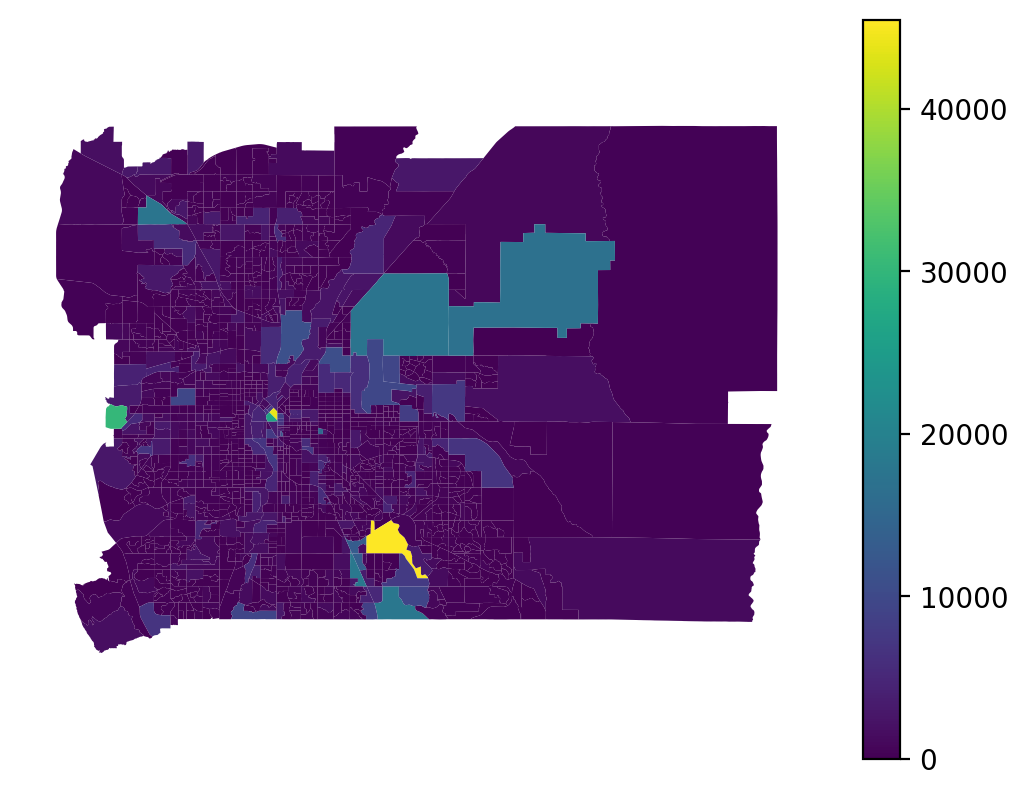

In [6]:
ax = smart_locations_db.plot(column="TOTAL_JOBS", facecolor="#fafafa", legend=True)
ax.axis("off")

### Get Walking Network

In [7]:
G_walk = ox.graph_from_polygon(denver_hull, network_type="walk")

In [8]:
travel_speed = 4.8  # km/hr
walk_time_limit = 20  # mins

meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G_walk.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [9]:
def walk_radius(x, y):
    center_node = ox.distance.nearest_nodes(G_walk, x, y)
    subgraph = nx.ego_graph(
        G_walk, center_node, radius=walk_time_limit, distance="time"
    )
    node_points = [
        Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)
    ]
    bounding_poly = gp.GeoSeries(
        node_points, crs=G_walk.graph["crs"]
    ).unary_union.convex_hull
    return center_node, gp.GeoDataFrame(
        geometry=[bounding_poly], crs=G_walk.graph["crs"]
    )

<AxesSubplot:>

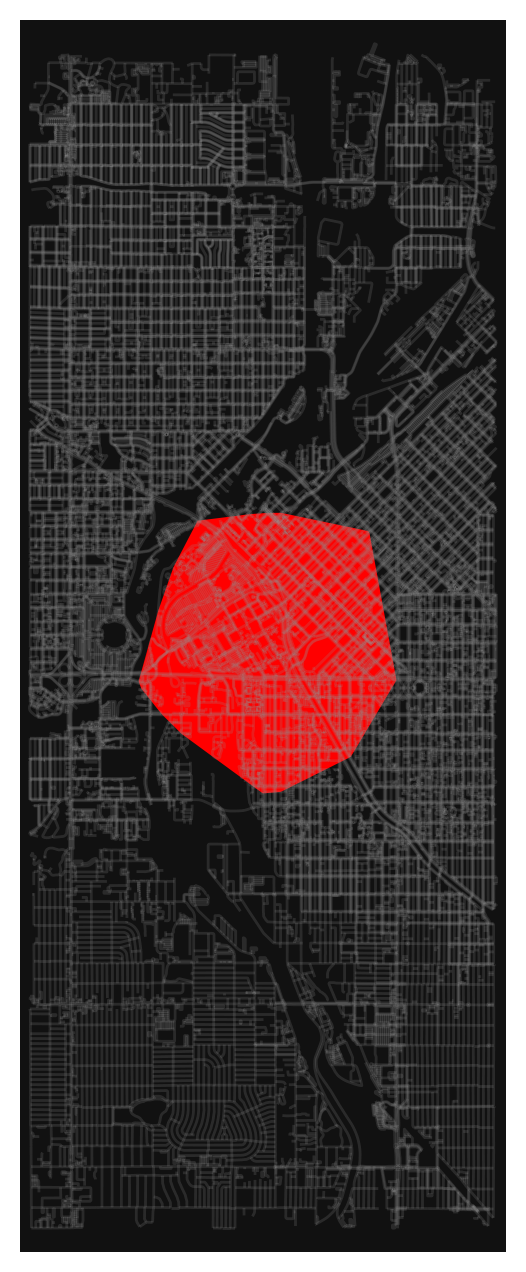

In [10]:
bbox = ox.utils_geo.bbox_from_point((-105.00296, 39.74338), dist=3_000)

center, radius = walk_radius(-105.00296, 39.74338)
G_walk_trunc = ox.truncate.truncate_graph_bbox(
    G_walk, (3 * bbox[3] + bbox[2]) / 4, (3 * bbox[2] + bbox[3]) / 4, bbox[1], bbox[0]
)

fig, ax = ox.plot_graph(
    G_walk_trunc,
    show=False,
    close=False,
    edge_color="#999999",
    edge_alpha=0.1,
    node_size=0,
)
radius.plot(ax=ax, color="red", ec="none", alpha=1, zorder=-1)

### Get Amenities Locations

In [11]:
light_rail_stations = ox.geometries_from_polygon(denver_hull, {"light_rail": "yes"})
supermarkets = ox.geometries_from_polygon(denver_hull, {"shop": "supermarket"})
schools = ox.geometries_from_polygon(denver_hull, {"amenity": "school"})

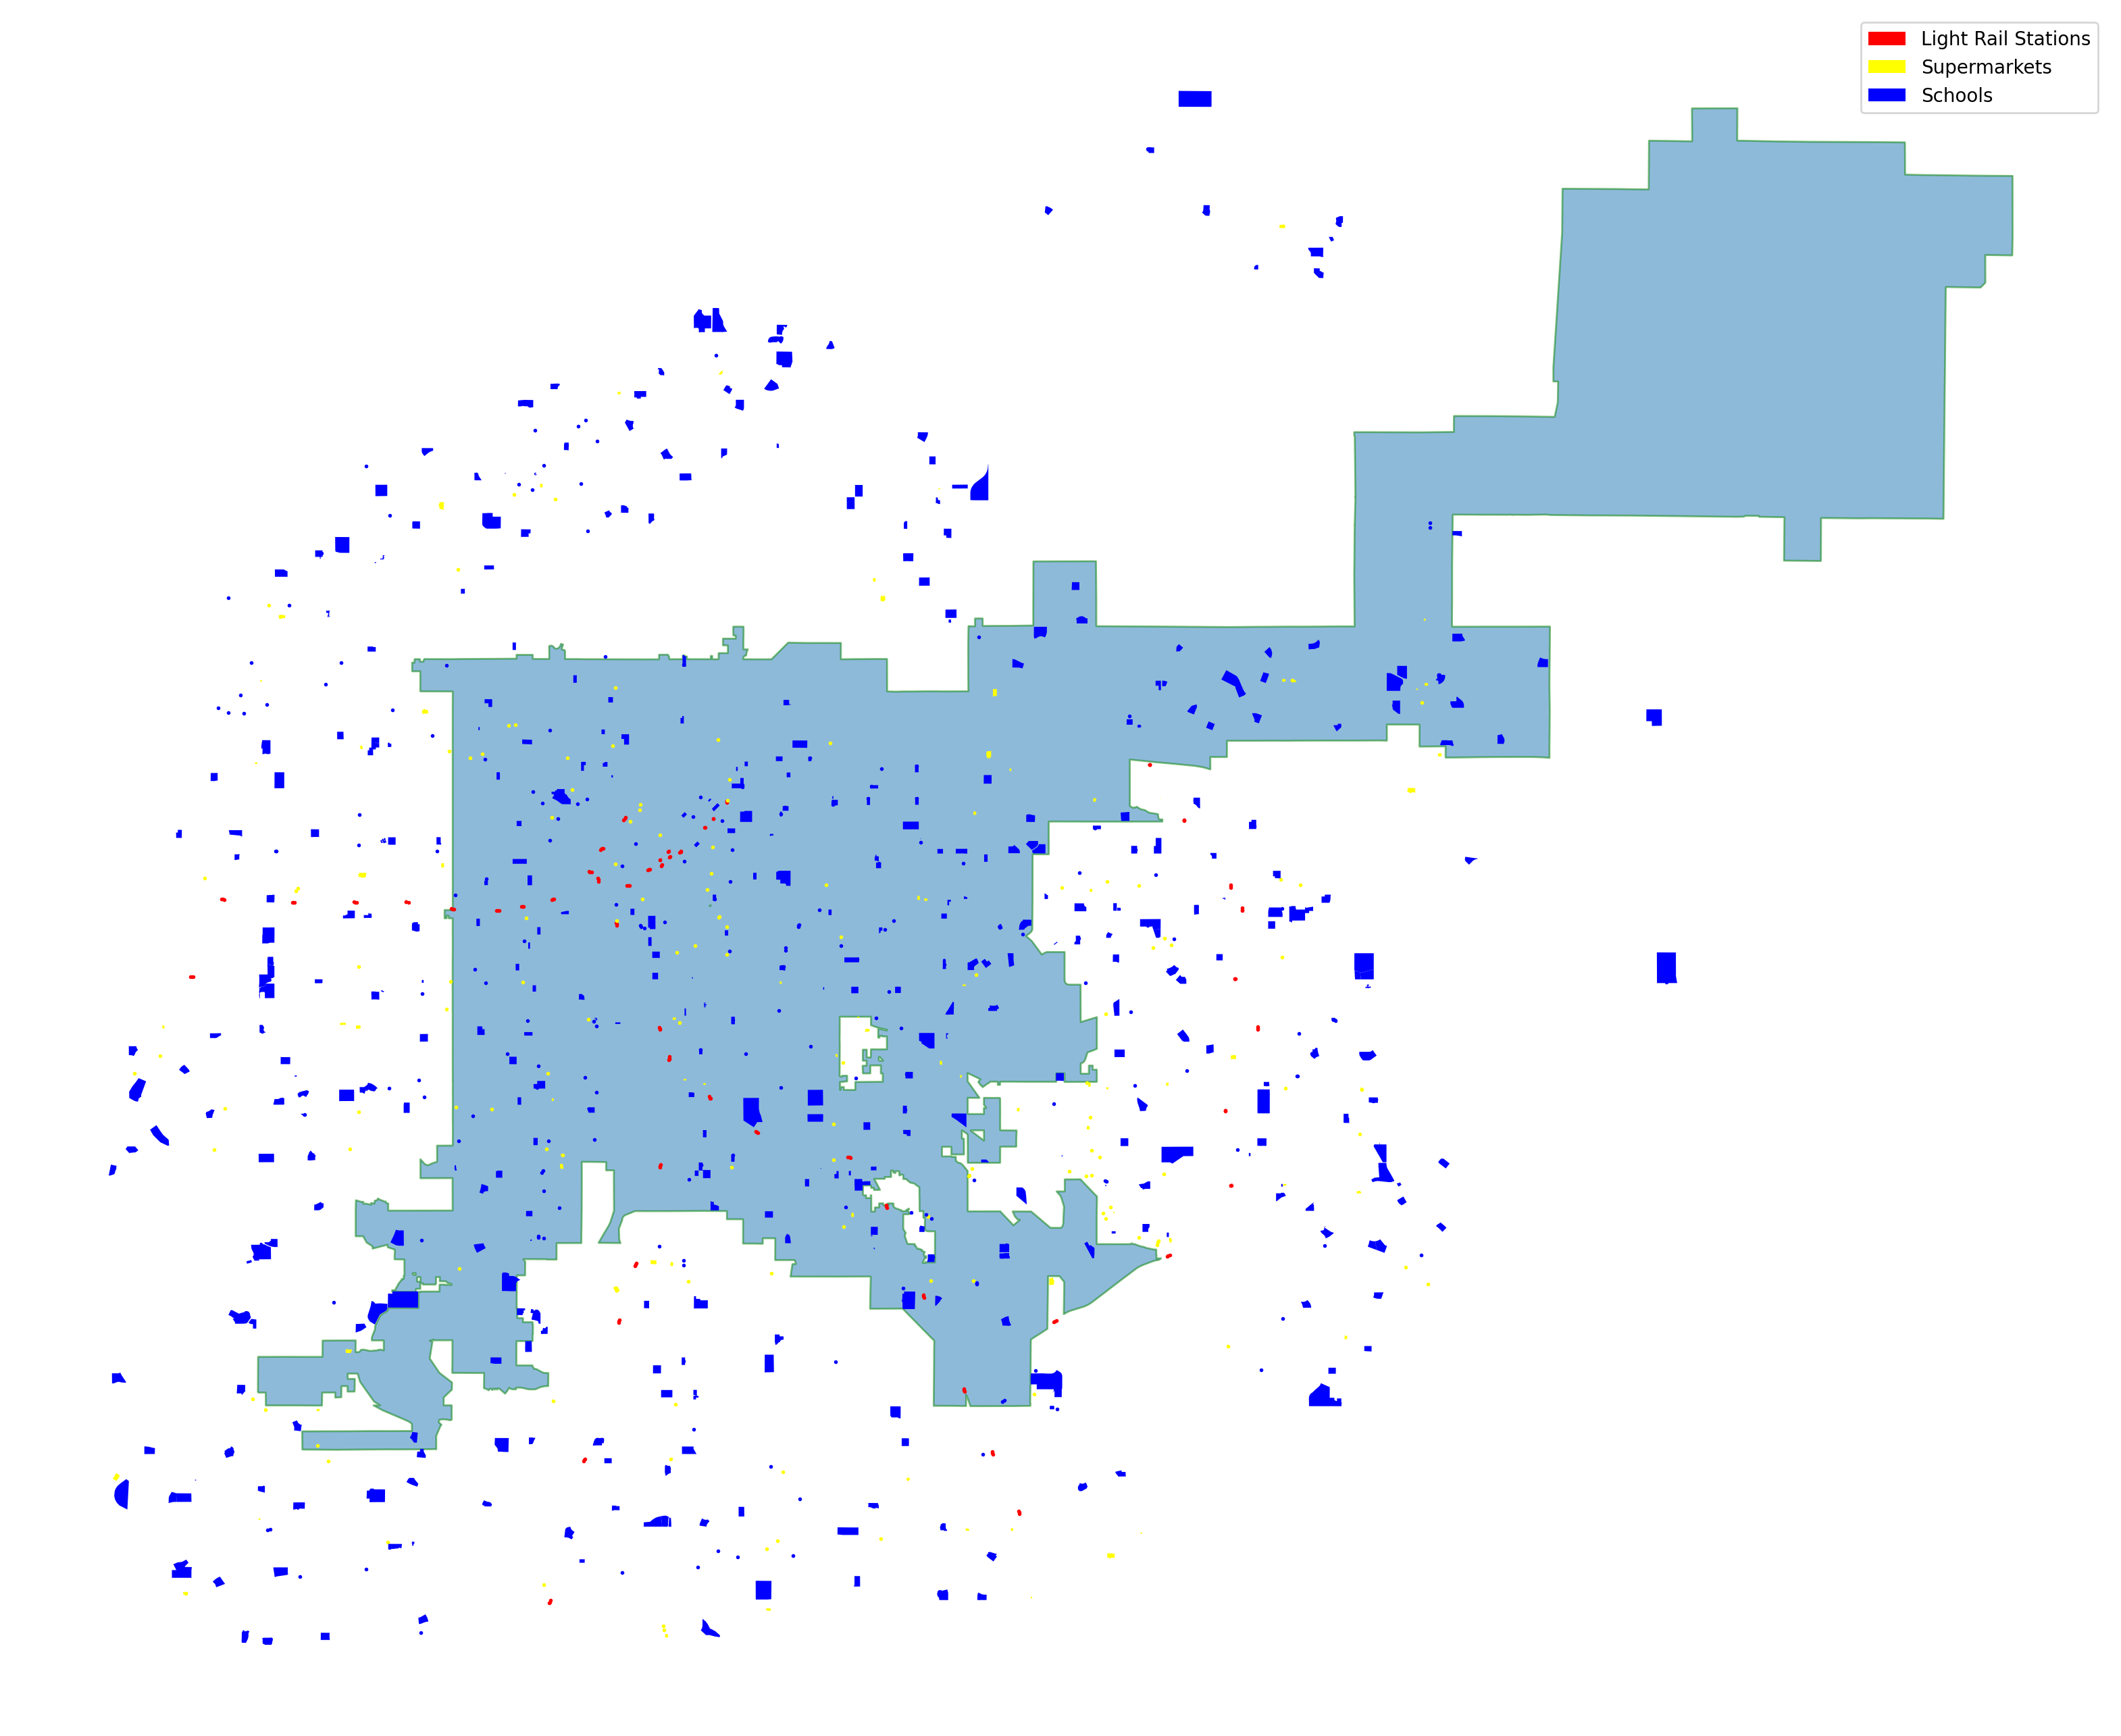

In [12]:
fig, ax = plt.subplots(figsize=(20, 20))

denver_gdf.plot(ax=ax, edgecolor="green", facecolor=None, alpha=0.5)
light_rail_stations.plot(ax=ax, markersize=1, color="red")
supermarkets.plot(ax=ax, markersize=1, color="yellow")
schools.plot(ax=ax, markersize=1, color="blue")
ax.axis("off")
ax.legend(
    [
        Patch(facecolor="red"),
        Patch(facecolor="yellow"),
        Patch(facecolor="blue"),
    ],
    ["Light Rail Stations", "Supermarkets", "Schools"],
)

### Parcel Data

In [13]:
parcels = gp.read_file("./data/parcels.shp")

In [14]:
vacant_parcels_mask = np.all(
    [
        (parcels["PROP_CLASS"].fillna(1000).astype(int) <= 600),
        parcels["ASSESSED_T"] > 300,
        parcels["LAND_AREA"] < 10 * 43_560,
    ],
    axis=0,
)

vacant_parcels = parcels[vacant_parcels_mask]

(-105.13539374000001, -104.57419046, 39.599305405, 39.929204095)

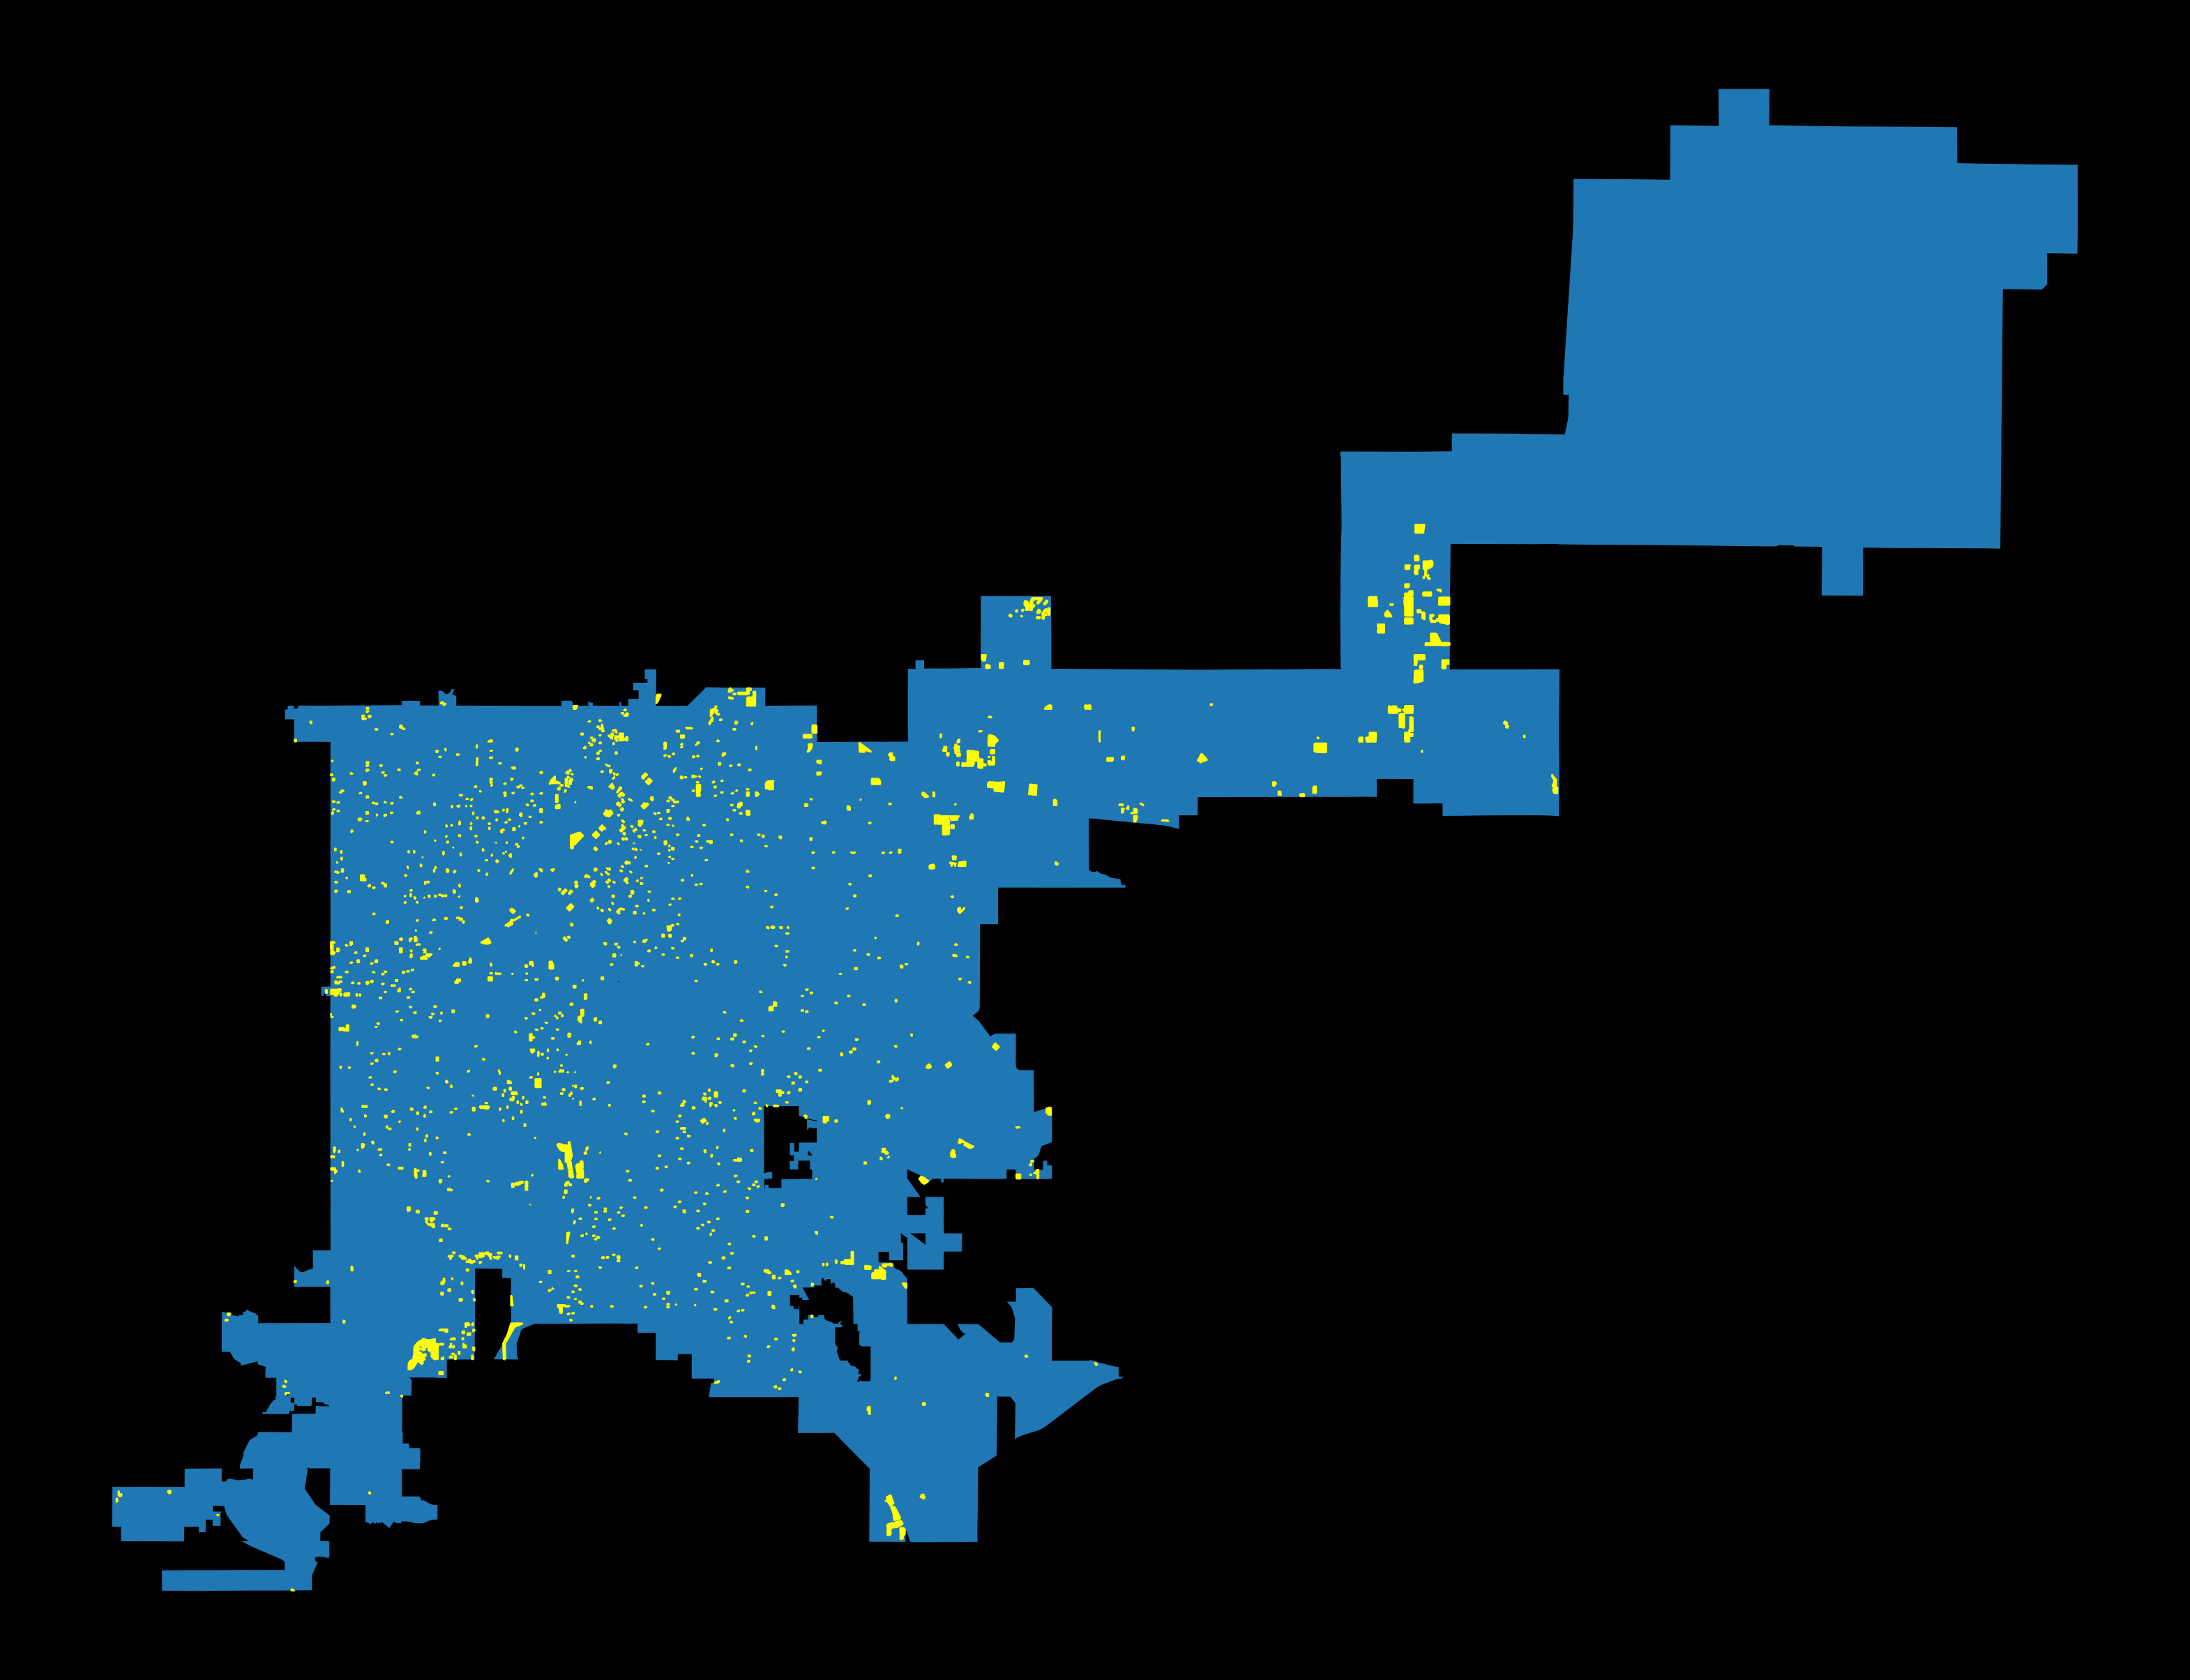

In [15]:
fig, ax = plt.subplots(figsize=(20, 20), facecolor="#000000")
denver_gdf.plot(ax=ax, zorder=-1)
vacant_parcels.plot(ax=ax, color="yellow", edgecolor="yellow")
ax.axis("off")

In [16]:
vacant_parcels["LAND_AREA"].sum() / 43_560

860.2280303030303

Text(0.5, 1.0, 'Vacant Lots (Colored by Price in $)')

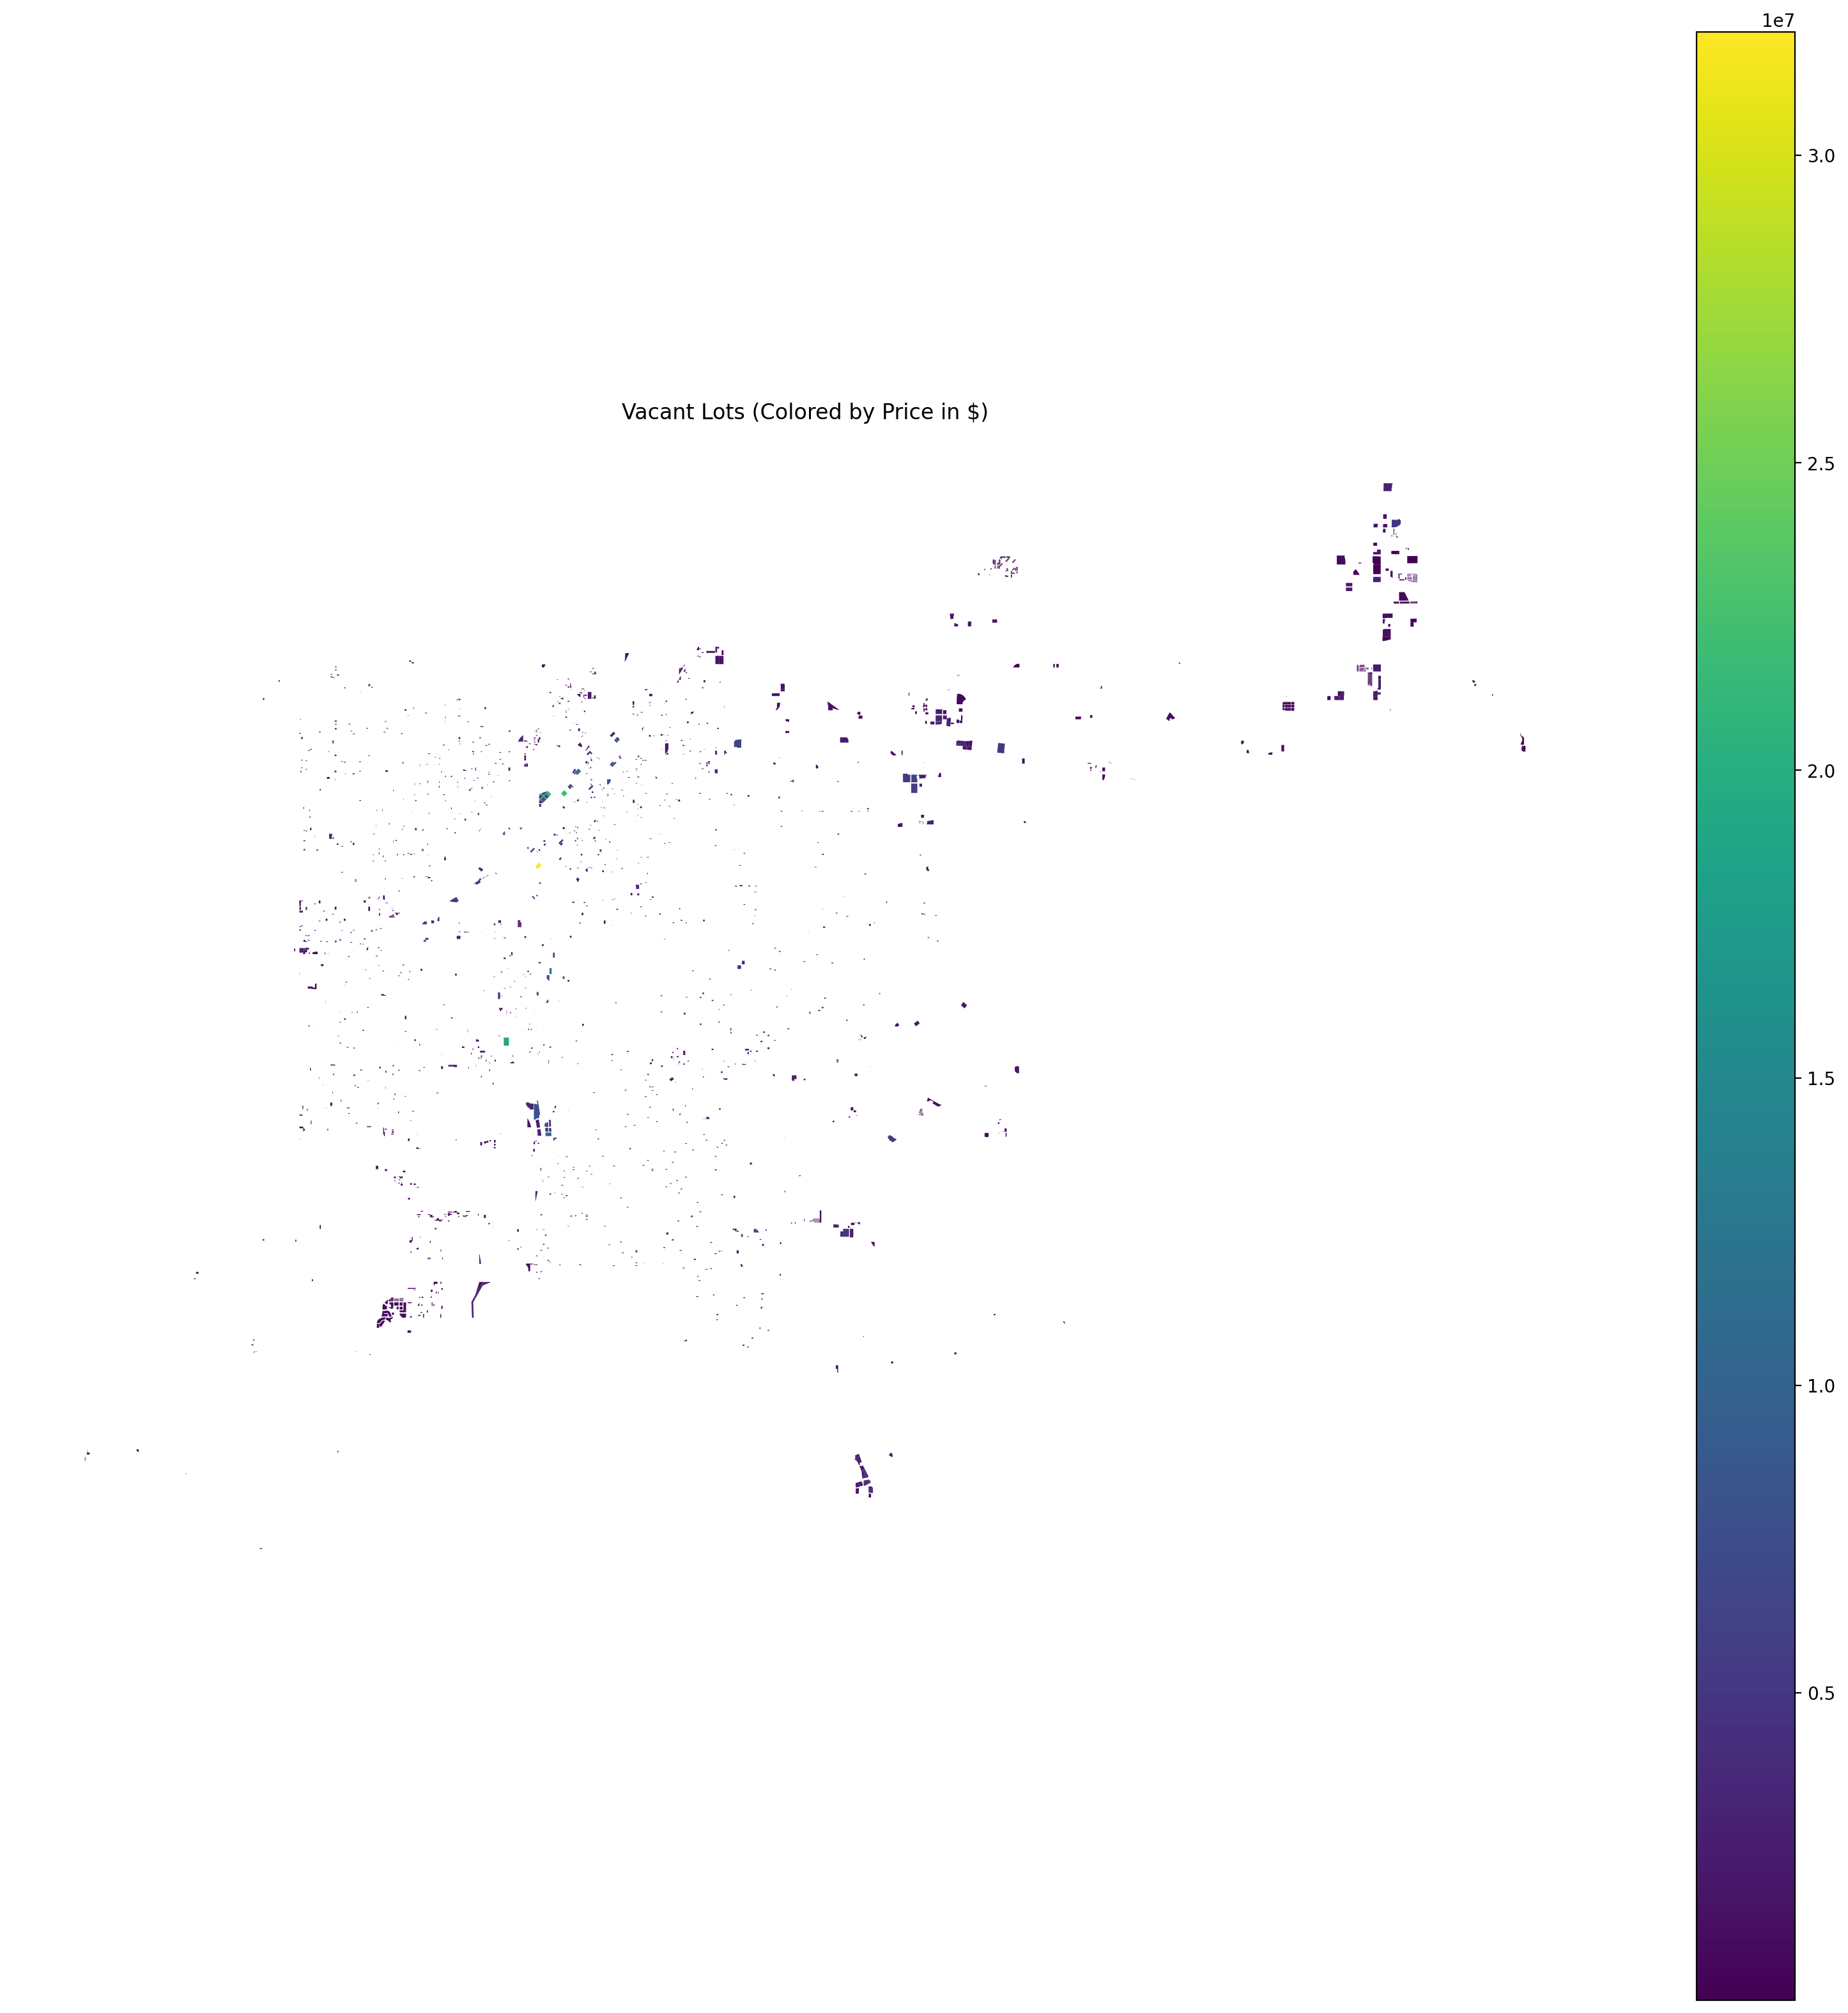

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))
vacant_parcels.plot(ax=ax, column="APPRAISE_1", legend=True)
ax.axis("off")
ax.set_title("Vacant Lots (Colored by Price in $)")

In [18]:
vacant_parcels.shape

(2643, 63)

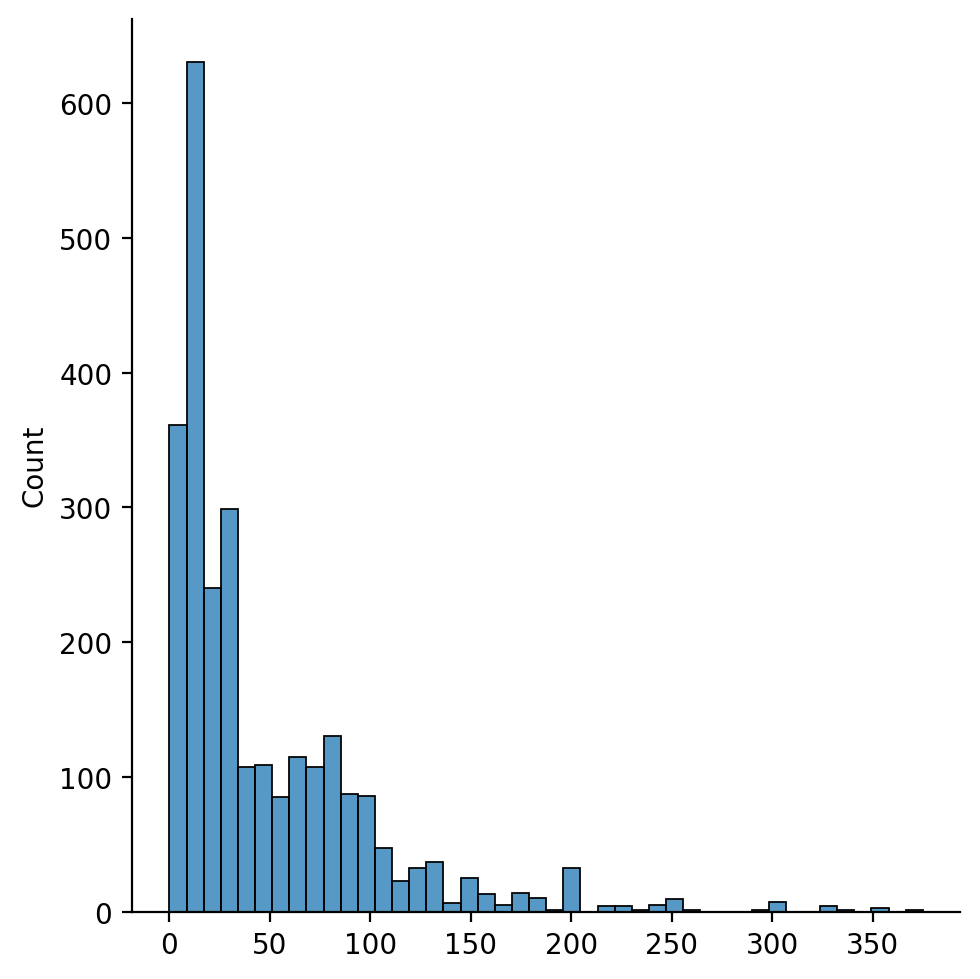

In [19]:
sns.displot(vacant_parcels["APPRAISE_1"] / vacant_parcels["LAND_AREA"])

## Housing Density

From https://www.brookings.edu/research/gentle-density-can-save-our-neighborhoods/, housing for 4-6 units can be placed on about 4,100 ft^2.

In [20]:
vacant_parcels["CAPACITY"] = np.floor(vacant_parcels["LAND_AREA"] * 5 / 4100)

/usr/local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [21]:
vacant_parcels["CAPACITY"].sum()

44320.0

## Measuring Walking Radius with Employment Density

In [22]:
def employment_overlap(radius):
    smart_locs_local = smart_locations_db.to_crs("ESRI:103245")
    radius = radius.to_crs("ESRI:103245").geometry.iloc[0]
    intersect_mask = smart_locs_local.geometry.intersects(radius)
    jobs = 0
    for area_id, area_df in smart_locs_local[intersect_mask].iterrows():
        jobs += area_df.geometry.intersection(radius).area * area_df["D1C"] / 4046.86
    return jobs

In [23]:
employment_overlap(radius)

89808.13024406228

## Filtering For Required Amenities

In [24]:
light_rail_coverage = []
for _station_name, station in tqdm.tqdm(
    light_rail_stations.iterrows(), total=light_rail_stations.shape[0]
):
    point = station.geometry.representative_point()
    _center, coverage = walk_radius(point.x, point.y)

    light_rail_coverage.append(coverage)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [1:14:17<00:00, 18.65s/it]


In [25]:
supermarket_coverage = []
for _name, market in tqdm.tqdm(supermarkets.iterrows(), total=supermarkets.shape[0]):
    point = market.geometry.representative_point()
    _center, coverage = walk_radius(point.x, point.y)

    supermarket_coverage.append(coverage)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [06:10<00:00,  1.85s/it]


In [26]:
school_coverage = []
for _name, school in tqdm.tqdm(schools.iterrows(), total=schools.shape[0]):
    point = school.geometry.representative_point()
    _center, coverage = walk_radius(point.x, point.y)

    school_coverage.append(coverage)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [22:28<00:00,  1.73s/it]


In [27]:
light_rail_coverage_union = unary_union(light_rail_coverage)
school_coverage_union = unary_union(school_coverage)
supermarket_coverage_union = unary_union(supermarket_coverage)

amenities_coverage = intersection(
    intersection(light_rail_coverage_union, school_coverage_union),
    supermarket_coverage_union,
)
amenities_coverage_no_rail = intersection(
    school_coverage_union,
    supermarket_coverage_union,
)

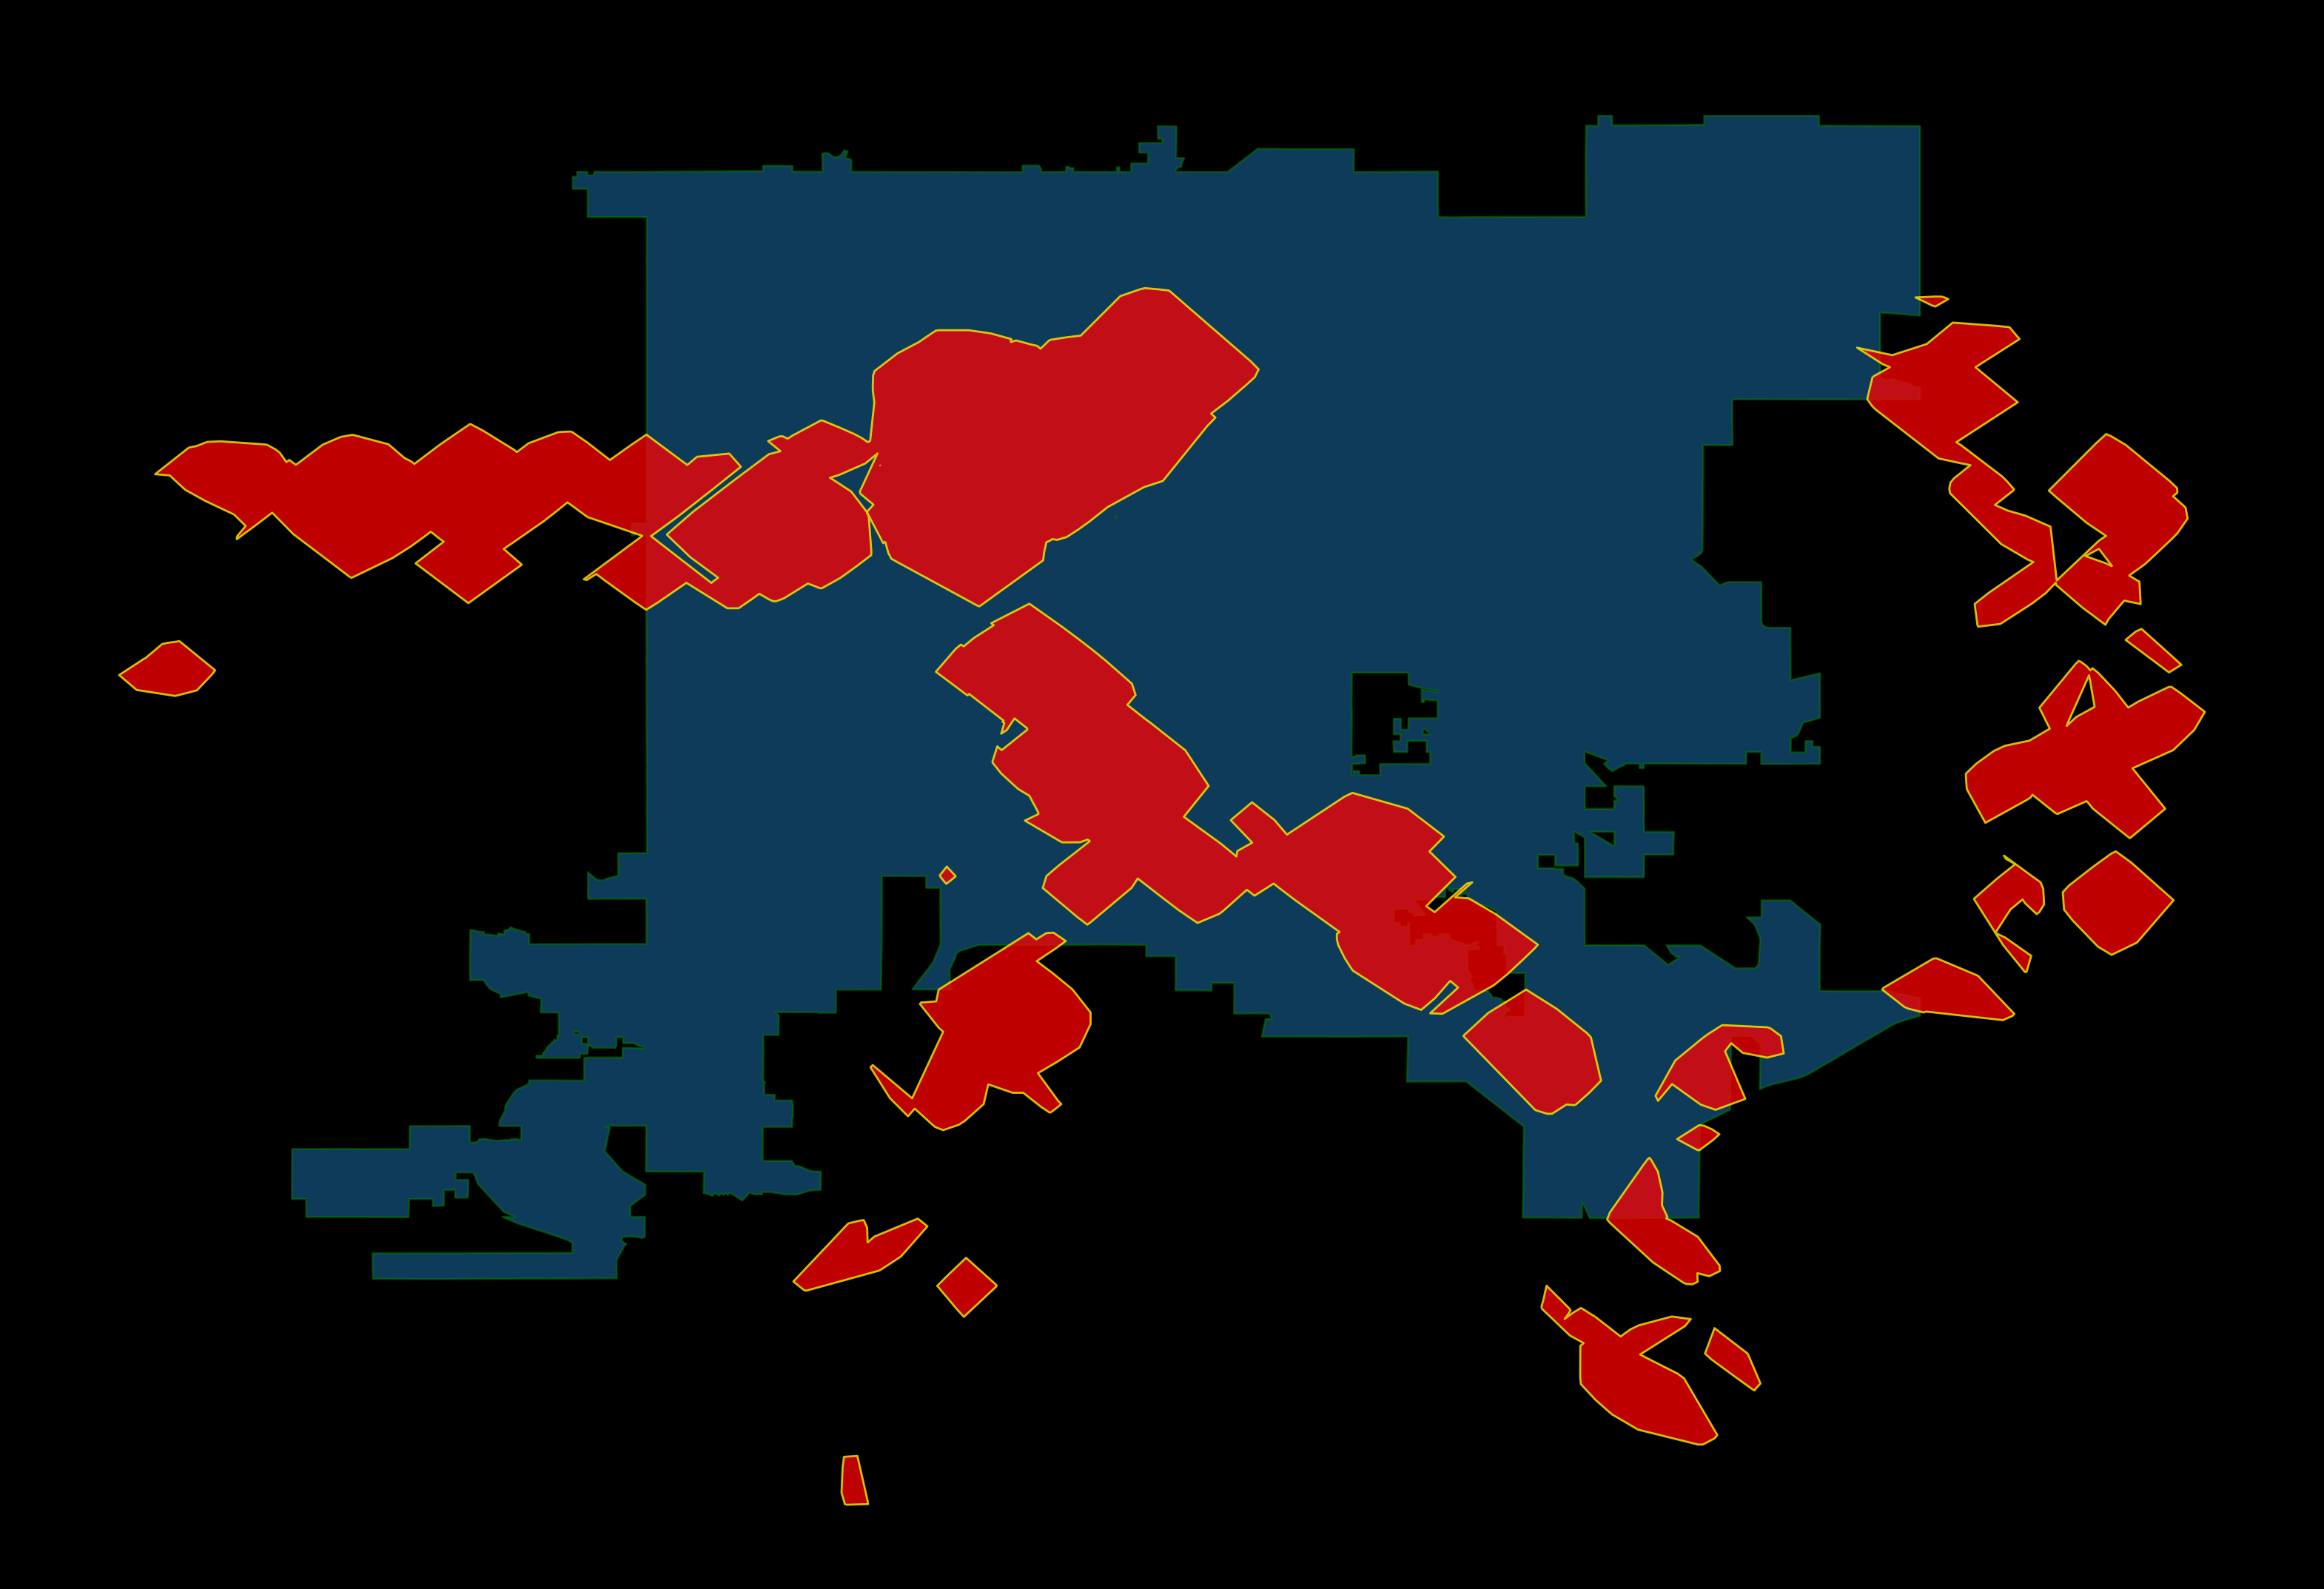

In [28]:
fig, ax = plt.subplots(figsize=(20, 20), facecolor="#000000")

central_denver_gdf.plot(ax=ax, edgecolor="green", facecolor=None, alpha=0.5)
gp.GeoSeries(amenities_coverage).plot(
    ax=ax, color="red", alpha=0.75, edgecolor="yellow"
)
ax.set_title(
    f"Areas within {walk_time_limit} min walk of a LightRail, a Supermarket, and a School"
)
ax.axis("off");

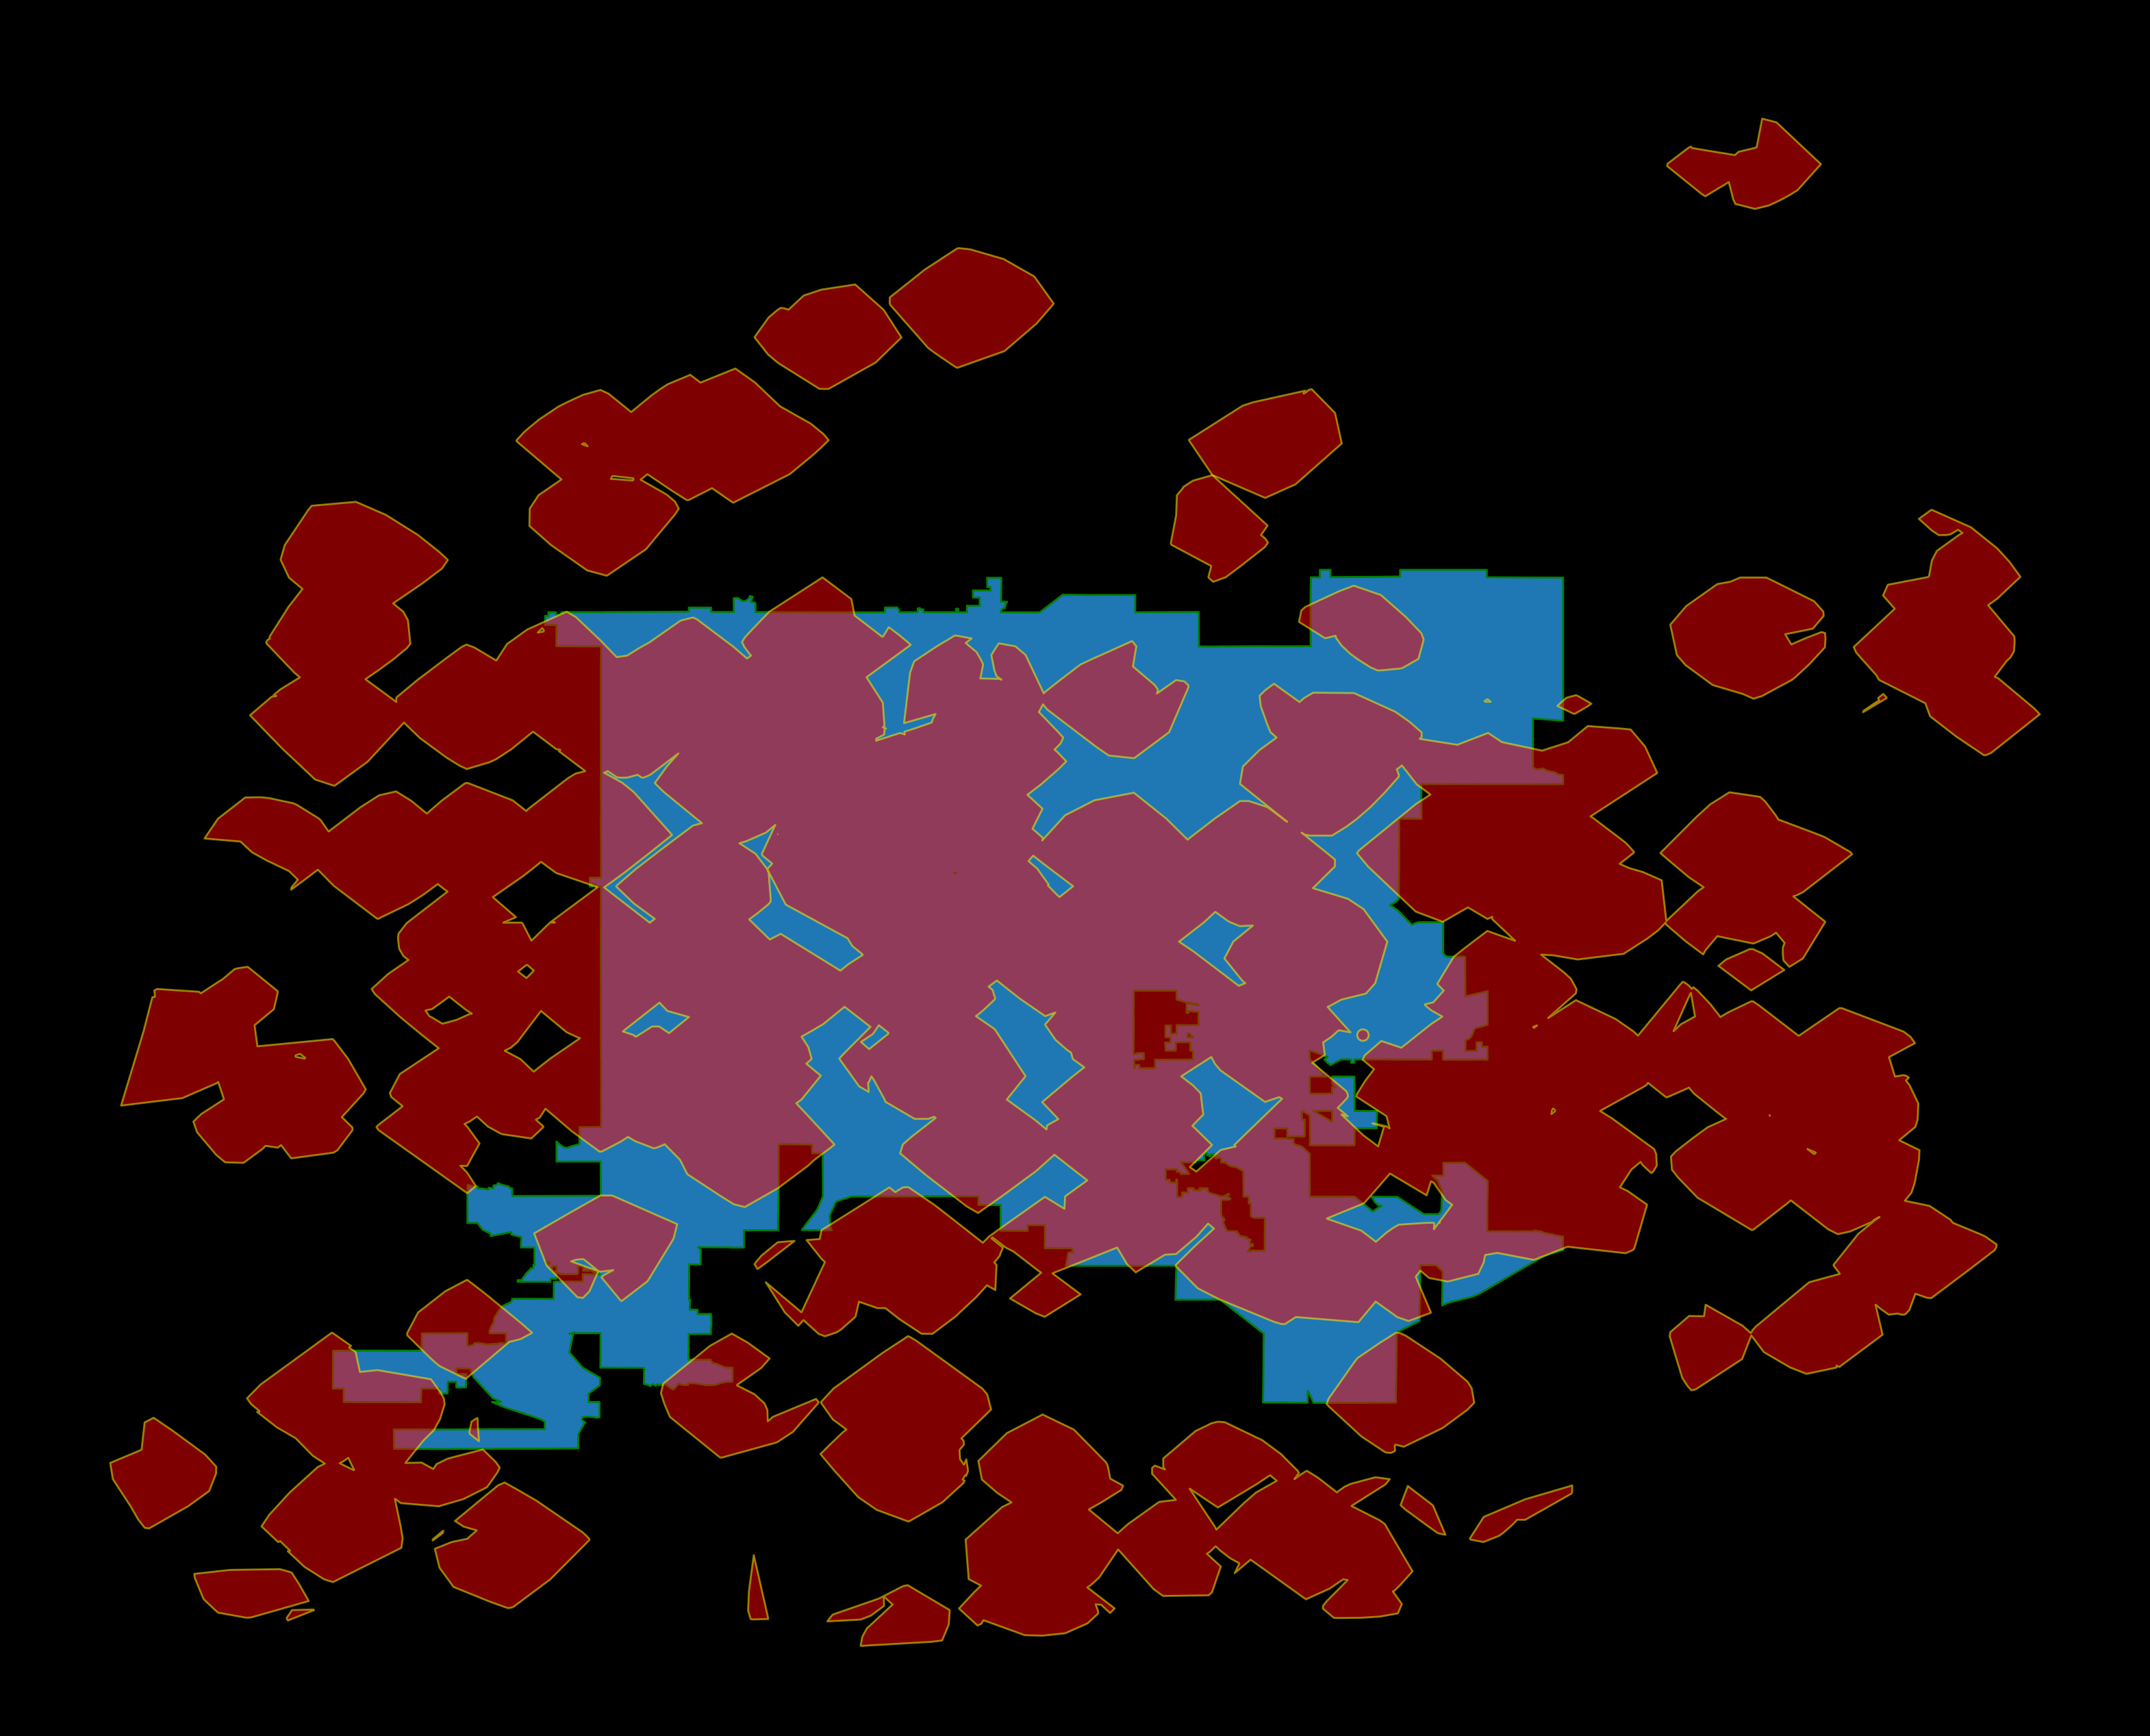

In [29]:
fig, ax = plt.subplots(figsize=(20, 20), facecolor="#000000")

central_denver_gdf.plot(ax=ax, edgecolor="green", facecolor=None, alpha=1)
gp.GeoSeries(amenities_coverage_no_rail).plot(
    ax=ax, color="red", alpha=0.5, edgecolor="yellow"
)
ax.set_title(f"Areas within {walk_time_limit} min walk of a Supermarket and a School")
ax.axis("off");

In [30]:
vacant_parcels_with_amenities = vacant_parcels[
    vacant_parcels.geometry.intersects(amenities_coverage)
]

(-105.12307210707114, -104.83294475150632, 39.60501584, 39.80928496)

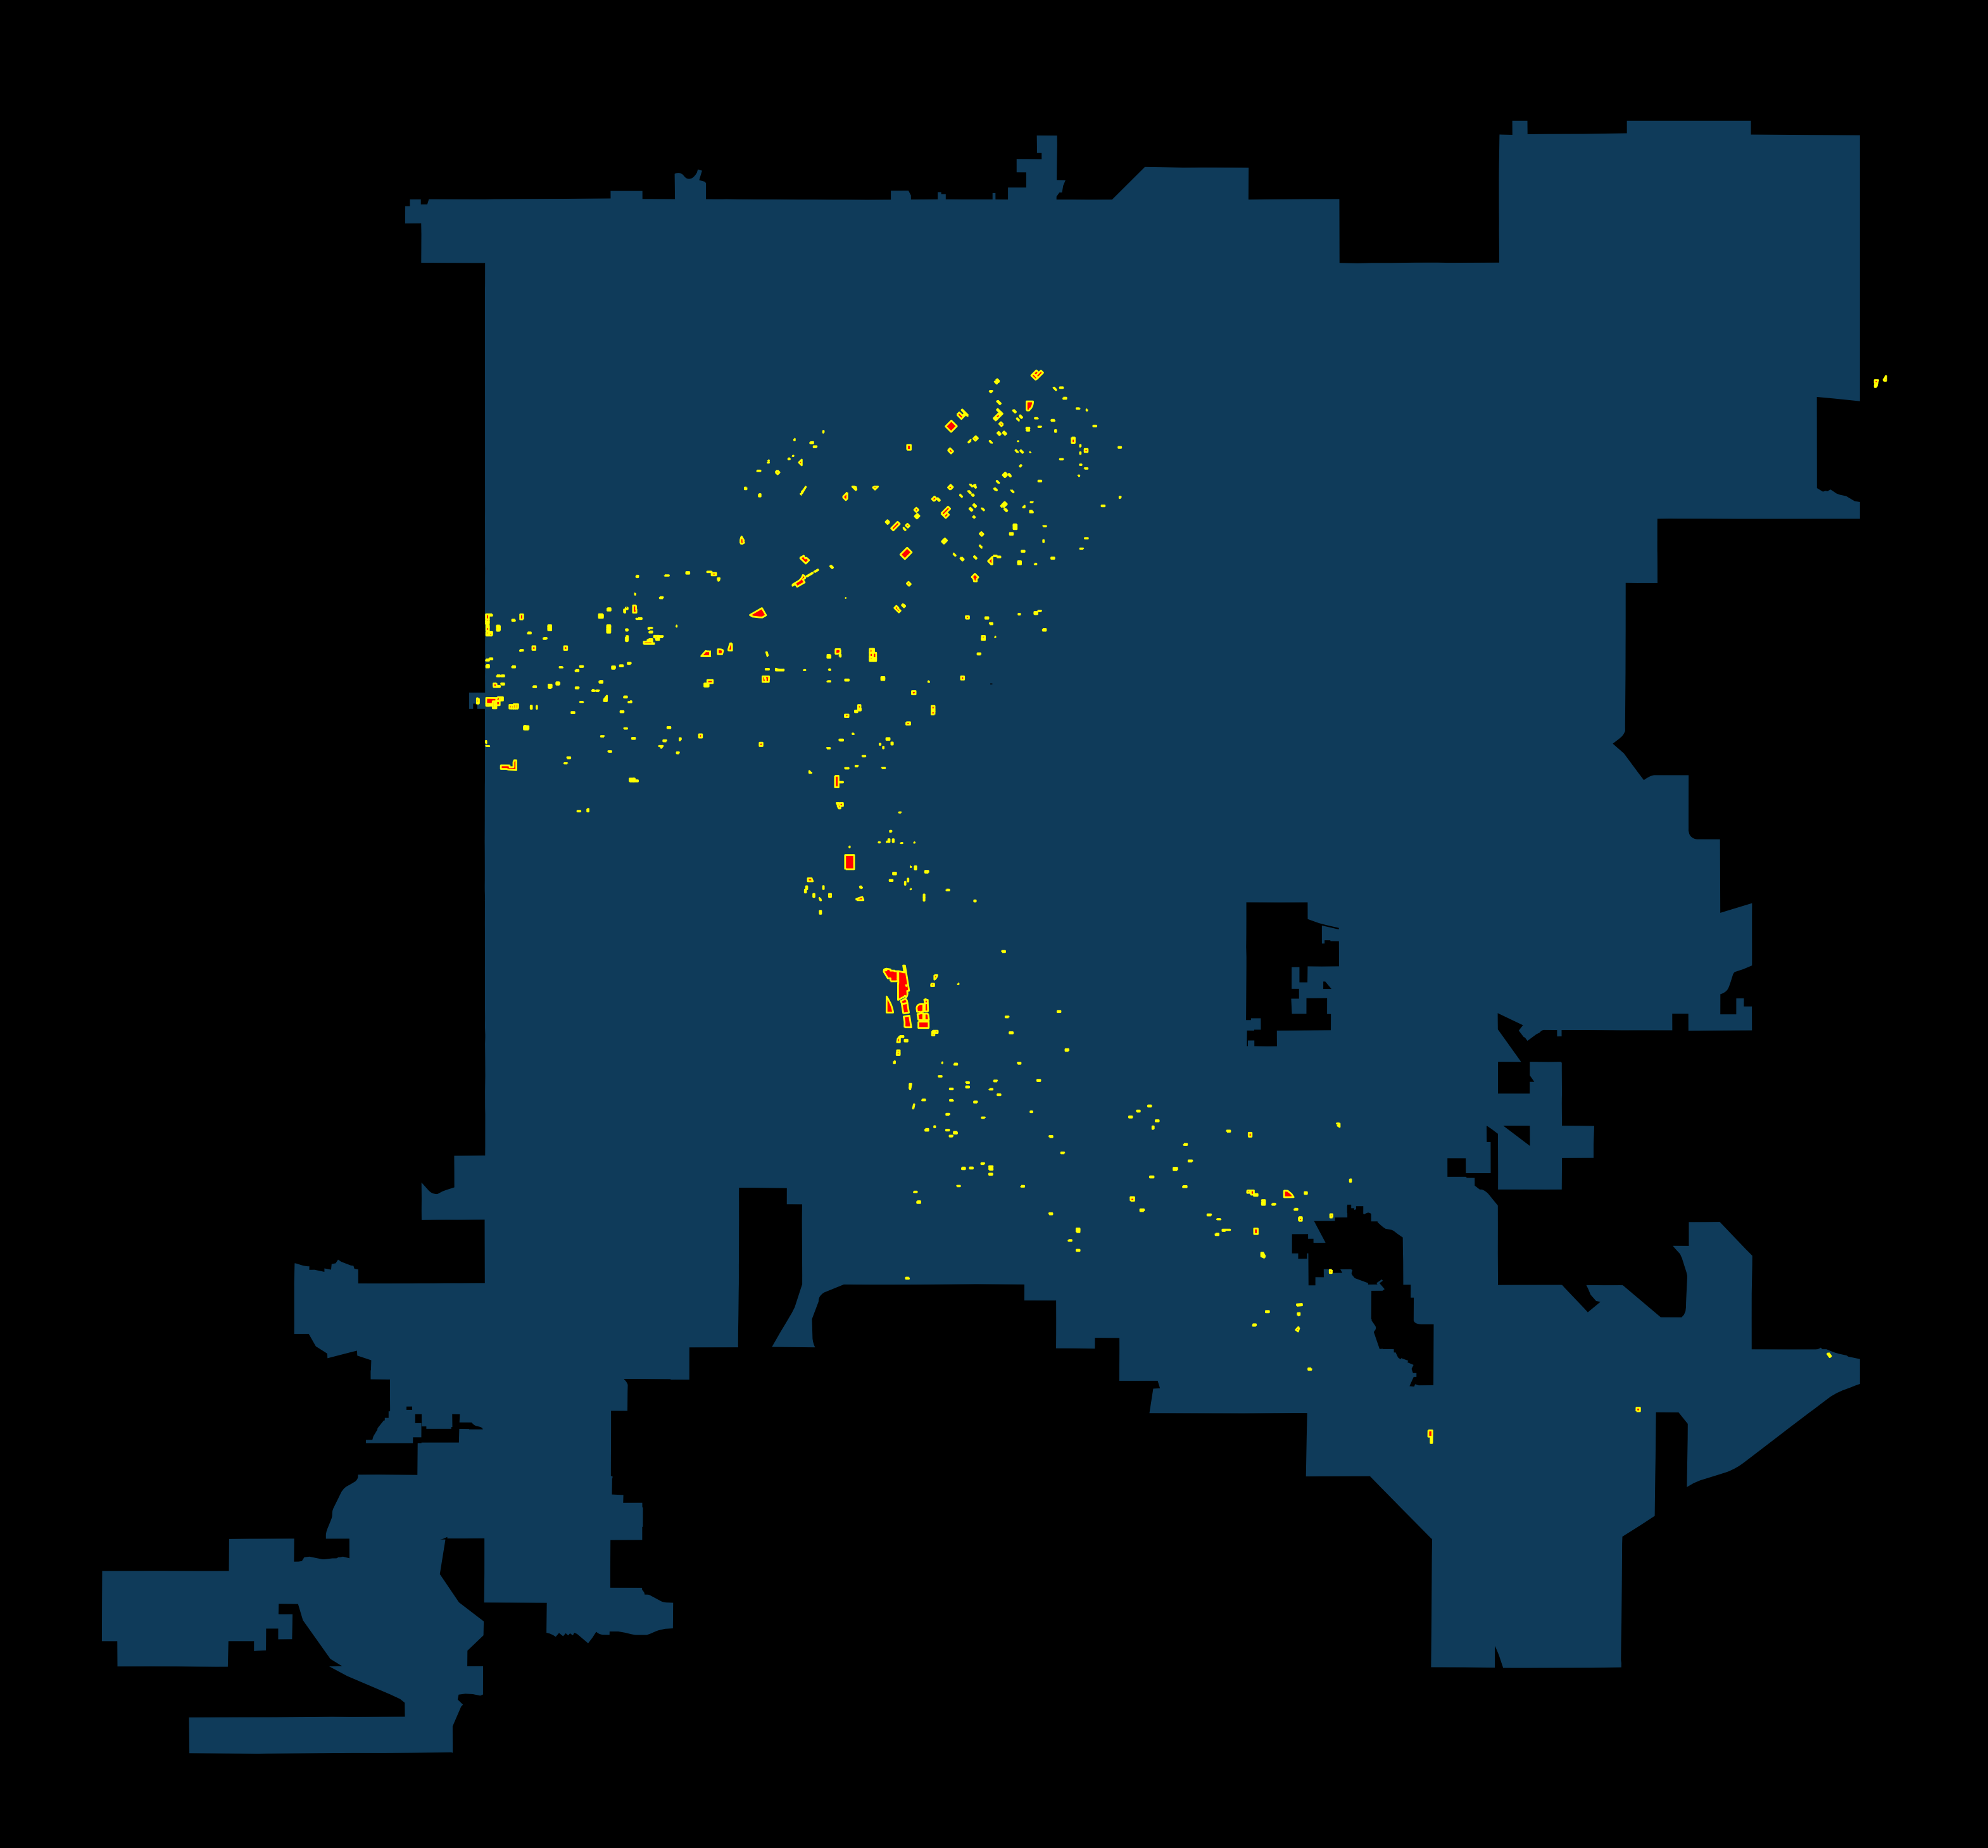

In [31]:
fig, ax = plt.subplots(figsize=(20, 20), facecolor="#000000")

central_denver_gdf.plot(ax=ax, facecolor=None, alpha=0.5)
vacant_parcels_with_amenities.plot(ax=ax, color="red", edgecolor="yellow")

ax.set_title(
    f"Parcels within {walk_time_limit} min walk of a LightRail, a Supermarket, and a School"
)
ax.axis("off")

In [32]:
eo_series = {}
for parcel_id, parcel_df in tqdm.tqdm(
    vacant_parcels_with_amenities.iterrows(),
    total=vacant_parcels_with_amenities.shape[0],
):
    point = parcel_df.geometry.representative_point()
    _center, walking_coverage = walk_radius(point.x, point.y)
    eo_series[parcel_id] = employment_overlap(walking_coverage)

eo_series = pd.Series(eo_series)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 587/587 [22:16<00:00,  2.28s/it]


In [33]:
vacant_parcels_with_amenities = vacant_parcels_with_amenities.copy()
vacant_parcels_with_amenities["employment_coverage"] = eo_series

In [34]:
vacant_parcels_with_amenities

,SCHEDNUM,MAPNUM,BLKNUM,PARCELNUM,APPENDAGE,PARCEL_SOU,SYSTEM_STA,OWNER_NAME,OWNER_ADDR,OWNER_AD_1,...,TOT_UNITS,RECEPTION_,ASAL_INSTR,SALE_DATE,SALE_MONTH,SALE_YEAR,SALE_PRICE,geometry,CAPACITY,employment_coverage
83,0505424021000,05054,24,021,000,NaN,2010-12-09,ABARCA FOUR LLC,2645 W 7TH AVE,NaN,...,0,2019076087,WD: WARRANTY,2019-06-14,0614,2019.0,0.0,"POLYGON Z ((-105.02117 39.72989 0.00000, -105....",21.0,5979.446171
1469,0227809040000,02278,09,040,000,NaN,2023-01-19,RPAI CHESTNUT LP,2731 17TH ST STE 300,NaN,...,0,2022129047,OR: ORDINANCE,2022-10-07,1007,2022.0,0.0,"POLYGON Z ((-104.99855 39.75840 0.00000, -104....",17.0,49250.215826
1987,0227615029000,02276,15,029,000,NaN,2012-09-12,EPWORTH HOUSING FOUNDATION,3401 N HIGH ST,NaN,...,0,2012111306,QC: QUIT CLAIM,2012-08-17,0817,2012.0,0.0,"POLYGON Z ((-104.97680 39.75609 0.00000, -104....",0.0,28125.947186
2135,0522108047000,05221,08,047,000,NaN,2015-03-11,US BANK NATIONAL ASSOCIATION,PO BOX 460169,NaN,...,0,NaN,NaN,NaN,NaN,0.0,0.0,"POLYGON Z ((-104.98677 39.69647 0.00000, -104....",14.0,8850.082201
2245,0503707029000,05037,07,029,000,NaN,2019-01-08,RPAI BANNOCK LP,2731 17TH ST STE 300,NaN,...,0,2021143774,SW: SPECIAL WARRANTY,2021-07-30,0730,2021.0,4750000.0,"POLYGON Z ((-104.99097 39.73160 0.00000, -104....",19.0,69283.510520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236449,0227624024000,02276,24,024,000,Sanborn,2022-02-23,RIPLEY RIDGE LLC,2365 BELLAIRE ST,NaN,...,0,2022054980,PR: PERSONAL REP,2022-04-21,0421,2022.0,1970000.0,"POLYGON Z ((-104.98083 39.75865 0.00000, -104....",2.0,30202.453550
236527,0524311001000,05243,11,001,000,NaN,2010-12-09,"KEMPER,THOMAS M",1658 S MILWAUKEE ST,NaN,...,0,2010099302,QC: QUIT CLAIM,2010-08-26,0826,2010.0,10.0,"POLYGON Z ((-104.95689 39.68731 0.00000, -104....",7.0,4677.824673
237370,0506123061000,05061,23,061,000,NaN,2022-10-27,STUART RESIDENCES LLC,915 S PEARL ST,NaN,...,0,2022132482,PS: PARCEL SPLIT,2022-10-19,1019,2022.0,0.0,"POLYGON Z ((-105.04224 39.73587 0.00000, -105....",3.0,2925.437030
237427,0233511064000,02335,11,064,000,NaN,2010-12-08,ASCENT ARENA AND DEVELOPMENT CORP,1000 CHOPPER CIR,NaN,...,0,0000124112,BG: BARGAIN & SALE,1998-07-29,0729,1998.0,7500000.0,"POLYGON Z ((-105.00546 39.74825 0.00000, -105....",10.0,74328.477472


## Optimize A

In [35]:
add_to_path("/Users/schmidmt/Downloads/ampl_macos64")
ampl = AMPL()
ampl.eval(
    r"""
    set PARCELS ordered;
    param COST {PARCELS};
    param EMPLOYMENT_COVERAGE {PARCELS};
    param CAPACITY {PARCELS};
    
    param TOTAL_DEMAND;
    
    var x{PARCELS} binary;
    
    minimize TOTAL_COST:
        sum {p in PARCELS} x[p] * COST[p];
        
    maximize TOTAL_COVERAGE:
        sum {p in PARCELS} x[p] * EMPLOYMENT_COVERAGE[p];
        
    subject to TOTAL_UNITS:
        sum {p in PARCELS} x[p] * CAPACITY[p] >= TOTAL_DEMAND;
"""
)

ampl.set["PARCELS"] = vacant_parcels_with_amenities.index.values
ampl.param["COST"] = vacant_parcels_with_amenities["APPRAISE_1"]
ampl.param["EMPLOYMENT_COVERAGE"] = vacant_parcels_with_amenities["employment_coverage"]
ampl.param["CAPACITY"] = vacant_parcels_with_amenities["CAPACITY"]
ampl.param["TOTAL_DEMAND"] = 1000

ampl.option["solver"] = "gurobi"
ampl.solve()

Gurobi 10.0.0:Gurobi 10.0.0: optimal solution; objective 12827500
1 simplex iterations
1 branching nodes
Objective = TOTAL_COST


In [36]:
assert ampl.get_value("solve_result") == "solved"

In [37]:
ampl.get_objective("TOTAL_COST").get().value()

12827500.0

In [38]:
ampl.get_objective("TOTAL_COVERAGE").get().value()

141887.6668879313

In [39]:
selected_raw = ampl.get_variable("x").get_values().to_pandas()
selected_raw.index = selected_raw.index.astype(int)
selected_mask = selected_raw.astype(bool)
selected_mask = selected_mask["x.val"]

In [40]:
selected_vacant_parcels = vacant_parcels_with_amenities[selected_mask]

(-105.12307210707114, -104.83294475150632, 39.60501584, 39.80928496)

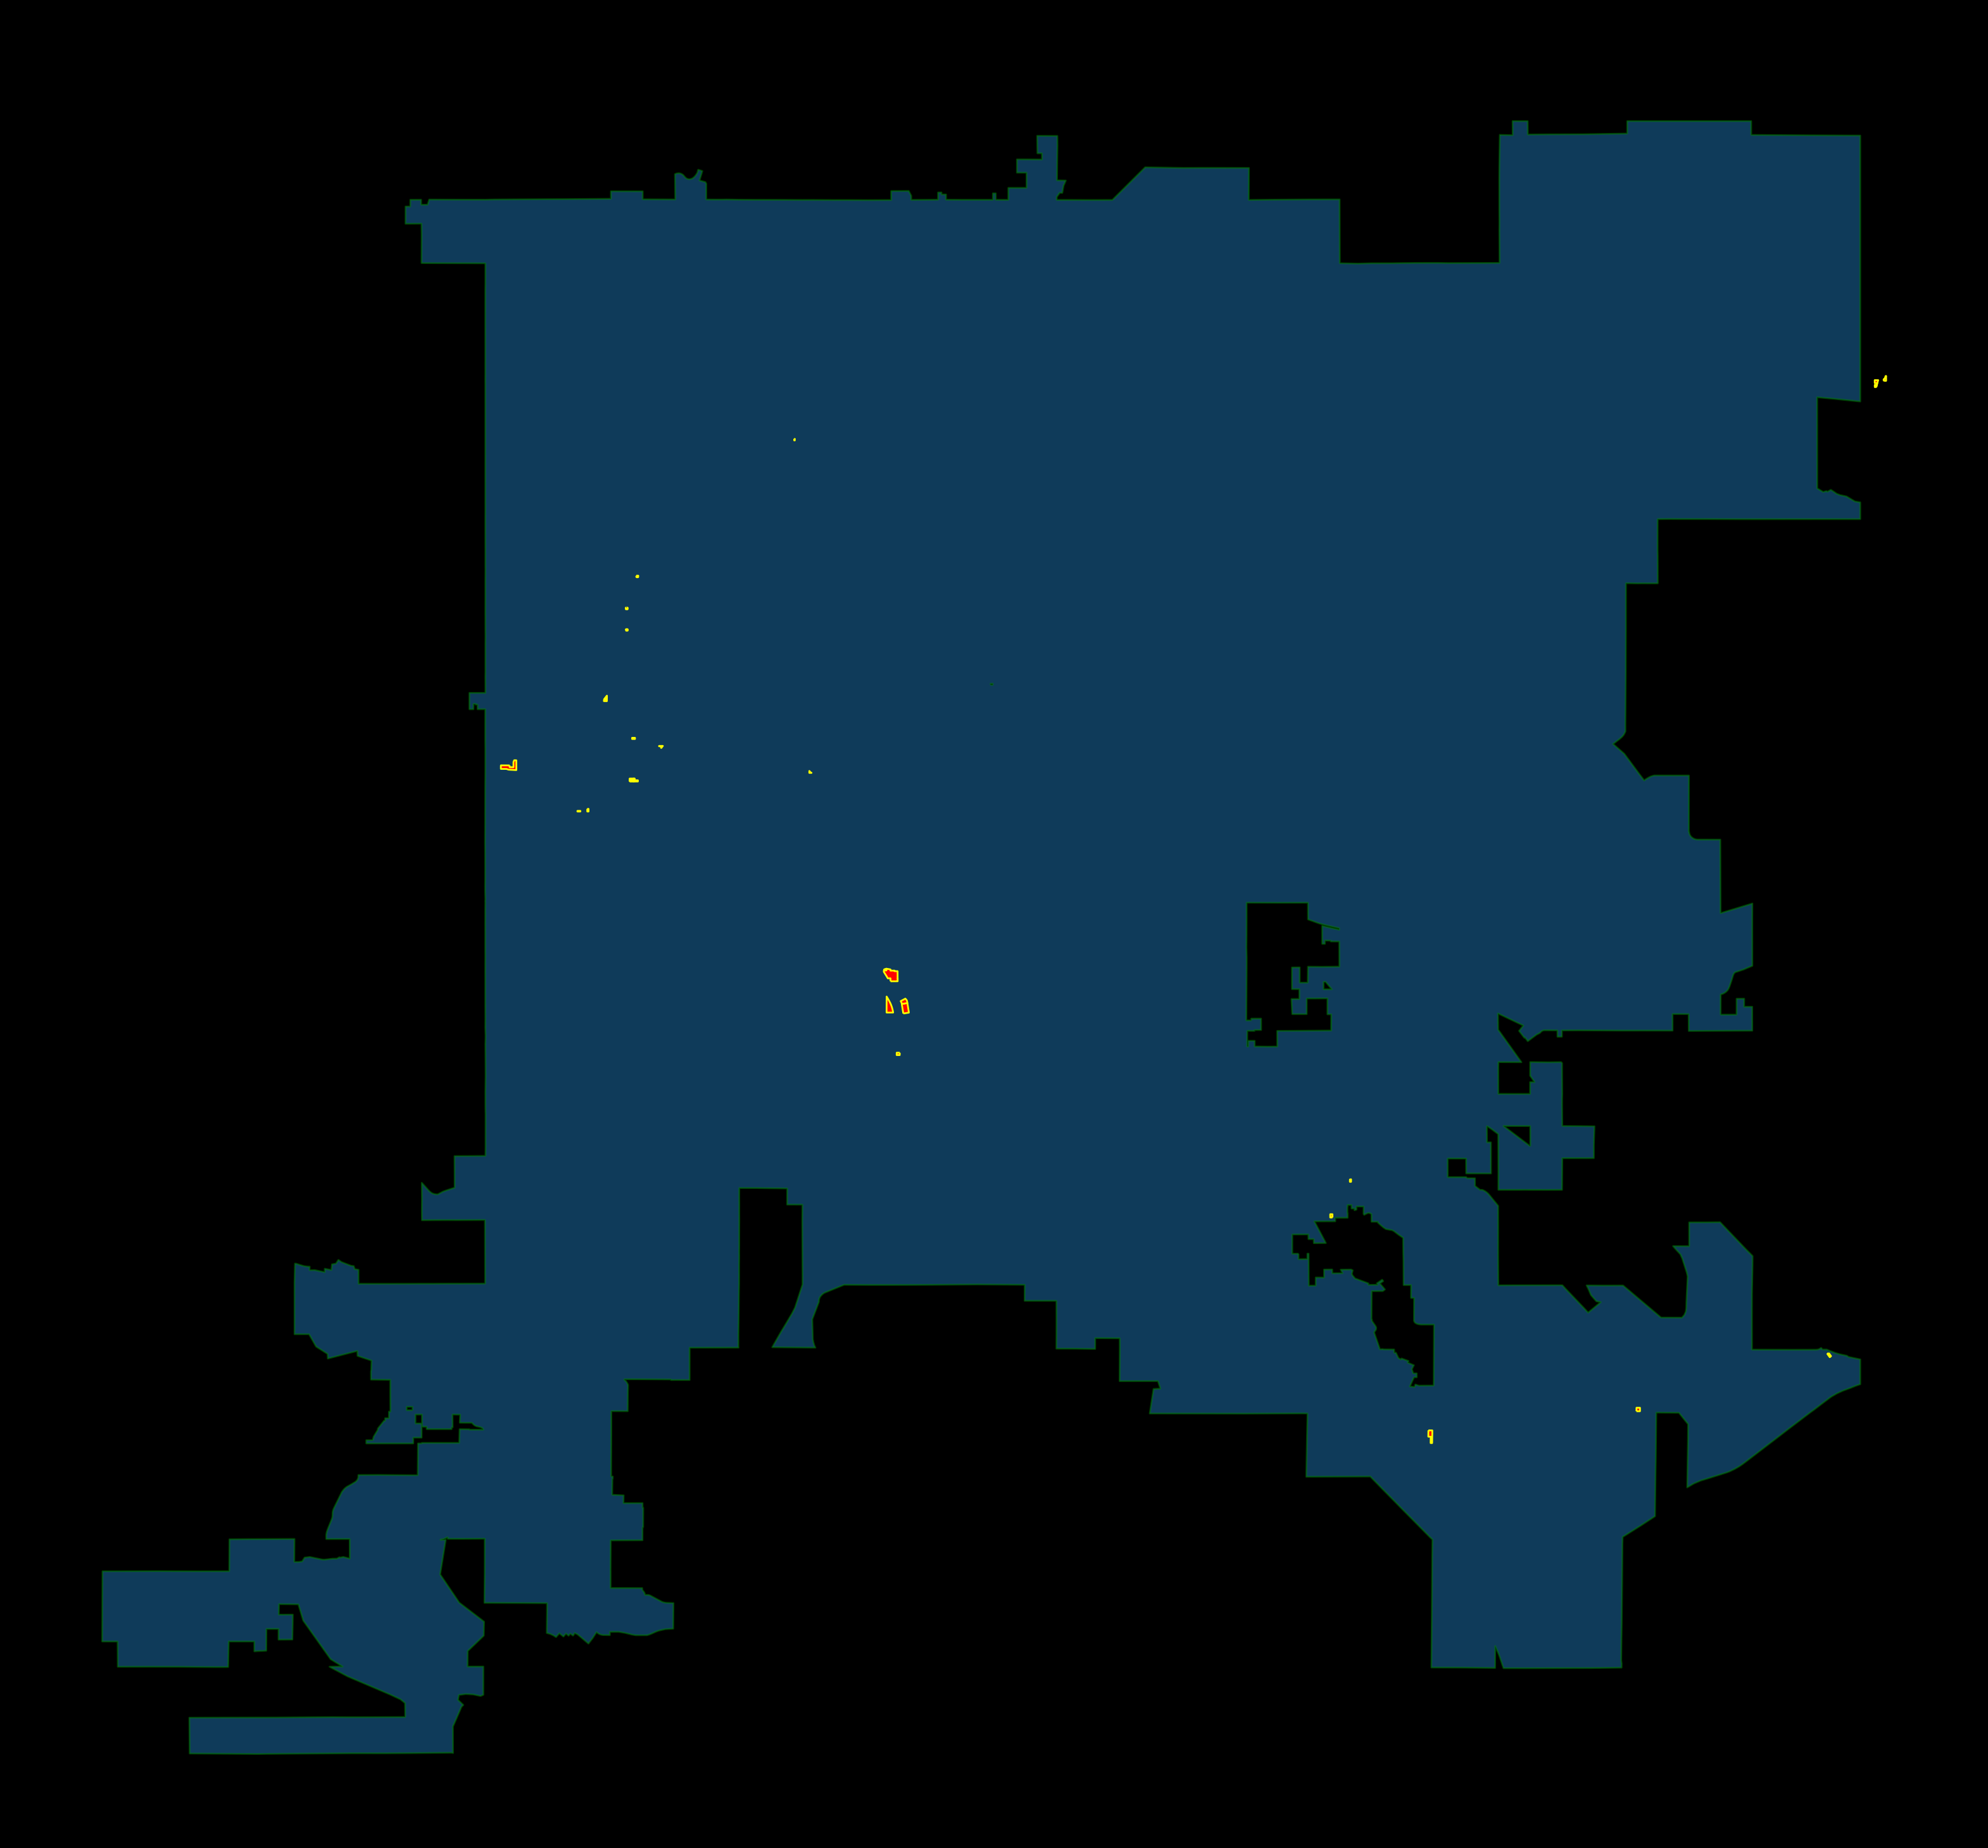

In [41]:
fig, ax = plt.subplots(figsize=(20, 20), facecolor="#000000")

central_denver_gdf.plot(ax=ax, edgecolor="green", facecolor=None, alpha=0.5)
selected_vacant_parcels.plot(ax=ax, color="red", edgecolor="yellow")

ax.set_title("Selected Parcels")
ax.axis("off")

In [42]:
selected_vacant_parcels.head()

,SCHEDNUM,MAPNUM,BLKNUM,PARCELNUM,APPENDAGE,PARCEL_SOU,SYSTEM_STA,OWNER_NAME,OWNER_ADDR,OWNER_AD_1,...,TOT_UNITS,RECEPTION_,ASAL_INSTR,SALE_DATE,SALE_MONTH,SALE_YEAR,SALE_PRICE,geometry,CAPACITY,employment_coverage
8457,0506416030000,05064,16,030,000,NaN,2022-09-26,HABITAT FOR HUMANITY OF METRO DENVER INC,3245 ELIOT ST,NaN,...,0,2022068733,QC: QUIT CLAIM,2022-05-17,0517,2022.0,0.0,"POLYGON Z ((-105.03567 39.73415 0.00000, -105....",11.0,1904.961318
22305,0232233014000,02322,33,014,000,Sanborn,2010-12-08,2085 IRVING STREET LLC,1478 E MAPLEWOOD CT,NaN,...,0,2017162264,SW: SPECIAL WARRANTY,2017-12-13,1213,2017.0,0.0,"POLYGON Z ((-105.03089 39.74827 0.00000, -105....",6.0,3797.288109
28507,0508305017000,05083,05,017,000,Sanborn,2010-12-09,CITYZEN DEVELOPMENT LLC,188 FEDERAL BLVD,NaN,...,0,2016008345,WD: WARRANTY,2016-01-22,0122,2016.0,500000.0,"POLYGON Z ((-105.03126 39.72506 0.00000, -105....",3.0,2346.805971
30315,0515502012000,05155,02,012,000,Sanborn,2022-08-10,BSP WEST LLC,4050 S 500,NaN,...,0,NaN,NaN,NaN,NaN,0.0,0.0,"POLYGON Z ((-104.99331 39.70214 0.00000, -104....",254.0,1778.654162
42673,0228225038000,02282,25,038,000,NaN,2010-12-08,"ARENCIBIA,JOSEPH",1745 W 33RD AVE,NaN,...,0,2019127601,BS: BARGAIN & SALE,2019-09-11,0911,2019.0,126100.0,"POLYGON Z ((-105.00754 39.76383 0.00000, -105....",2.0,8975.480448


In [43]:
selected_vacant_parcels["CAPACITY"].sum()

1000.0

## Optimize B

In [44]:
radii = dict()
for a_key, a in tqdm.tqdm(
    vacant_parcels_with_amenities.iterrows(),
    total=vacant_parcels_with_amenities.shape[0],
):
    point = a.geometry.representative_point()
    radii[a_key] = walk_radius(point.x, point.y)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 587/587 [19:08<00:00,  1.96s/it]


In [45]:
overlap_dict = dict()
for a_key, a in tqdm.tqdm(
    vacant_parcels_with_amenities.iterrows(),
    total=vacant_parcels_with_amenities.shape[0],
):
    for b_key, b in vacant_parcels_with_amenities.iterrows():
        if a_key == b_key:
            overlap_dict[(a_key, b_key)] = 0.0
        if a_key < b_key:
            ab_overlap = intersection(
                radii[a_key][1].geometry.iloc[0],
                radii[b_key][1].geometry.iloc[0],
            ).area
            overlap_dict[(a_key, b_key)] = ab_overlap
            overlap_dict[(b_key, a_key)] = ab_overlap

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 587/587 [00:54<00:00, 10.76it/s]


In [ ]:
overlap = pd.DataFrame(overlap_dict, index=np.arange(len(overlap_dict)))

add_to_path("/Users/schmidmt/Downloads/ampl_macos64")
ampl = AMPL()
ampl.eval(
    r"""
    set PARCELS ordered;
    param COST {PARCELS};
    param EMPLOYMENT_COVERAGE {PARCELS};
    param CAPACITY {PARCELS};
    param OVERLAP {PARCELS, PARCELS};
    
    param TOTAL_DEMAND;
    
    var x{PARCELS} binary;
    
    minimize TOTAL_COST:
        sum {p in PARCELS} x[p] * COST[p];
        
    maximize TOTAL_COVERAGE:
        sum {p in PARCELS} x[p] * EMPLOYMENT_COVERAGE[p];
        
    subject to TOTAL_UNITS:
        sum {p in PARCELS} x[p] * CAPACITY[p] >= TOTAL_DEMAND;
"""
)

ampl.set["PARCELS"] = vacant_parcels_with_amenities.index.values
ampl.param["COST"] = vacant_parcels_with_amenities["APPRAISE_1"]
ampl.param["EMPLOYMENT_COVERAGE"] = vacant_parcels_with_amenities["employment_coverage"]
ampl.param["CAPACITY"] = vacant_parcels_with_amenities["CAPACITY"]
ampl.param["TOTAL_DEMAND"] = 1000

ampl.option["solver"] = "gurobi"
ampl.solve()